In [1]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from IPython.display import display, Markdown
from plotly.subplots import make_subplots
import textwrap
import os

# BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import openai
from bertopic.representation import OpenAI
from sklearn.metrics.pairwise import cosine_similarity

# network analysis
import networkx as nx
from pyvis.network import Network
from adjustText import adjust_text
from networkx.algorithms.community import girvan_newman

import warnings
warnings.filterwarnings('ignore')

/Users/aneteyabbey/ki/tweedejaarsproject_bsc_ki/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **TABLE OF CONTENTS**:
- [DATASET](#dataset)
- [HOW TO USE](#how_to_use)
- [SEARCH DATASET](#search-dataset)
- [PARAMETERS BERTOPIC](#parameters)
- [LOAD DATA](#load-data)
- [EXECUTE BERT](#execute-bert)
- [ANALYZE CLUSTERS](#analyze-clusters)
  - [TOPIC BARCHART](#topic_barchart)
  - [TOPIC HIERARCHY](#topic_hierarchy)
  - [TOPIC DISTANCE MAP](#topic_distance)
- [MERGE CLUSTERS INTO DATASET](#merge_clusters)
- [OUTLIERS](#outliers)
- [TRANSFORM QUERY AND ASSIGN CLOSEST CLUSTER](#query_assign)
  - [ASSIGNED TOPICS WORDCLOUD](#topic_worldcloud)
- [VIZUALIZATIONS FOR ONE SPECIFIC TOPIC](#visual_one)
  - [PROJECTS IN TOPIC](#projects_topic)
  - [RELATED TOPICS](#topic_related)
- [VIZUALIZATIONS FOR MULTIPLE TOPICS](#visual_multiple)
  - [PROJECT COUNT OVER TIME](#project_count)
  - [DEPARTMENTS](#departments)
  - [SUB-DEPARTMENTS](#sub_departments)
  - [FUNDING SCHEMES](#funding)
  - [FUNDING SCHEMES IN DEPTH](#funding_depth)
- [COMPARING TWO TOPICS](#compare)
- [DEEP DIVE INTO TOPIC](#deep_dive)
- [NETWORK ANALYSIS](#network_analysis)
- [PREPROCESS DATA](#preprocess_data)
- [STATIC NETWORKS](#static_networks)
  - [AUTHOR CENTRALITY ANALYSIS](#author_centrality_analysis)
  - [AUTHOR IN FOCUS](#author_in_focus)
  - [AUTHORS AND DEPARTMENTS](#authors_and_departments)
  - [DEPARTMENT NETWORKS](#department_networks)
- [INTERACTIVE NETWORKS](#interactive_networks)
  - [AUTHOR NETWORKS OVER TIME](#author_networks_over_time)
  - [MISCELLANEOUS - EXTENSIVE INTERACTIVE NETWORKS](#misc_extensive_interactive_networks)
- [SOURCES](#sources)

## **HOW TO USE** <a class="anchor" id="how_to_use"></a>
1. Select dataset, it should be cleaned with the provided code in the data_preprocessing folder.
2. Input a query, from your query topics will be assigned. Similarity will be calculated between your query and each topic representation, from this the top $n$ topics will be selected.
3. Set parametes for BERTopic. Note: some visualizations have also paramters, those can be changed at the specific visualizations. To easily find these parameters, they will be marked with <font color='red'>**PARAMETER**</font>.
4. Run the whole notebook.
5. Use table of contents to get desired info. Note: Some visualizations allow you to change the topics you want to visualize, where this can be done will be marked with <font color='red'>**SELECT**</font><br>


## **DATASET** <a class="anchor" id="dataset"></a>

In [2]:
DATASET = "../data/nwo_df_projects_eng.pkl" # dataset name / location
EXPORT_TOPICS = False # set to true if you want to export all topics
DF_TOPICS = "df_topics_info.csv" # set name for exported topics data (must be .csv)
EXPORT_TOPICS_MERGED = False # set to true if you want to export dataset with topics
DF_TOPICS_MERGED = "df_projects_merged_topics.csv" # set name for exported dataset with topics (must be .csv)

## **SEARCH DATASET** <a class="anchor" id="search-dataset"></a>

In [3]:
# input your project query here, e.g. roman empire alexander the great greece
QUERY = ['sustainability industry innovation process technology innovation raw materials circularity consumption goods']

## **PARAMETERS BERTopic** <a class="anchor" id="parameters"></a>

Here are the parameters for BERTopic. We set them to the values that we believe are best.

In [4]:
# the model
LOAD_EMBEDDINGS = True  # set to True if embeddings are pre-saved
LOAD_MODEL = True  # set to True if a model is pre-saved
# the number of words per topic that you want to be extracted. These words are most representative of the topic.
N_WORDS_REPRESENTATION = 8
# the number of words you want in your topic representation. If you want 'Circular Economy' in your representations, set it to (1,2)
N_GRAM_RANGE = (1, 2)
# the minimum size of a topic. Lower means more topics, higher means less topics.
MIN_TOPIC_SIZE = 8

# assigning topics
TOPIC_COUNT = 8  # number of topics to identify; higher values will reduce accuracy
MIN_PROJECTS_CLUSTER = 0 # set higher to filter out topics with few projects

## **LOAD DATA** <a class="anchor" id="load-data"></a>

In [5]:
df_projects = pd.read_pickle(DATASET)

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # None means all data will be displayed in one line
pd.set_option('display.max_colwidth', 50)  # None means all data will be displayed without truncation

print(df_projects.shape)
display(df_projects.head(1))

(14078, 17)


,project_id,parent_project_id,title,funding_scheme_id,funding_scheme,department,sub_department,start_date,end_date,summary_nl,summary_en,project_members,products,start_year,text,language,token_count
0,612.001.210,None,enhancing efficiency and expressiveness of the...,2691,Vrije competitie Vrije competitie EW 2012 EW,Exacte en Natuurwetenschappen,Exacte Wetenschappen,2014-08-01,2018-12-31T00:00:00,Coalgebraic coinduction generalises the bisimu...,coalgebraic coinduction generalises the bisimu...,"[{'role': 'Project leader', 'member_id': 99959...",[{'title': 'Regular varieties of automata and ...,2014,enhancing efficiency and expressiveness of the...,en,314


## **EXECUTE BERT** <a class="anchor" id="execute-bert"></a>

In [7]:
# GPT-3.5
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""

client = openai.OpenAI()
openai_model = OpenAI(client, model="gpt-3.5-turbo-0125", exponential_backoff=True, chat=True, prompt=prompt)

representation_model = {
    "OpenAI": openai_model
}

In [8]:
docs = list(df_projects.text.values) # create stacked list of abstracts

if LOAD_EMBEDDINGS:
    # load embeddings
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = np.load('embeddings/nwo/embeddings.npy')
else:
    # pre-embed abstracts
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = sentence_model.encode(docs, show_progress_bar=True)
    
    # Ensure the directory exists
    save_dir = 'embeddings/nwo/'
    os.makedirs(save_dir, exist_ok=True)
    
    # save embeddings
    np.save(os.path.join(save_dir, 'embeddings.npy'), embeddings)

In [9]:
if LOAD_MODEL:
    # load the BERTopic model
    topic_model = BERTopic.load("models/nwo/BERTopic")

    # use the transform method to obtain topics and probabilities for the new documents
    topics, probs = topic_model.transform(docs, embeddings)
else:
    vectorizer_model = CountVectorizer(stop_words="english")
    
    topic_model = BERTopic(verbose=True, 
                        calculate_probabilities=True,
                        top_n_words=N_WORDS_REPRESENTATION,
                        n_gram_range=N_GRAM_RANGE,
                        min_topic_size=MIN_TOPIC_SIZE,
                        vectorizer_model=vectorizer_model,
                        representation_model=representation_model,
                        embedding_model=sentence_model)

    topics, probs = topic_model.fit_transform(docs, embeddings)
    
    # Ensure the directory exists
    save_dir = 'models/nwo/'
    os.makedirs(save_dir, exist_ok=True)

    # save the model
    embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
    topic_model.save(os.path.join(save_dir, "BERTopic"), serialization="safetensors", save_embedding_model=embedding_model)

2024-06-21 12:12:52,948 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


In [10]:
# add chatgpt labels to the model
chatgpt_topic_labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in topic_model.topic_aspects_["OpenAI"].items()}
chatgpt_topic_labels[-1] = "Outlier Topic"
topic_model.set_topic_labels(chatgpt_topic_labels)

topic_model.get_topic_info().head(2)

,Topic,Count,Name,CustomName,Representation,OpenAI,Representative_Docs
0,-1,5826,-1_research_project_students_education,Outlier Topic,"[research, project, students, education, new, ...",[Innovative Education Research Development],NaN
1,0,271,0_universe_galaxies_stars_radio,Topic: Cosmology and Galaxy Formation,"[universe, galaxies, stars, radio, dark, galax...",[Topic: Cosmology and Galaxy Formation],NaN


## **ANALYZE CLUSTERS** <a class="anchor" id="analyze-clusters"></a>

In [11]:
# show most prominent topics
df_topic_info = topic_model.get_topic_info()
df_topic_info.head(2)

,Topic,Count,Name,CustomName,Representation,OpenAI,Representative_Docs
0,-1,5826,-1_research_project_students_education,Outlier Topic,"[research, project, students, education, new, ...",[Innovative Education Research Development],NaN
1,0,271,0_universe_galaxies_stars_radio,Topic: Cosmology and Galaxy Formation,"[universe, galaxies, stars, radio, dark, galax...",[Topic: Cosmology and Galaxy Formation],NaN


In [12]:
if EXPORT_TOPICS is True:
    df_topic_info.to_csv(DF_TOPICS, index=False)

**Topic -1 are outliers**

#### **TOPIC BARCHART** <a class="anchor" id="topic_barchart"></a>

In [13]:
topic_model.visualize_barchart(top_n_topics=8, n_words=20, custom_labels=True, width=400)

#### **TOPIC HIERARCHY** <a class="anchor" id="topic_hierarchy"></a>

This plot shows the cluster hierarchy. Since we use HDBSCAN as a clustering algorthim, this means that clusters within clusters can be formed. To understand how these are related to each other we can use the plot below. A color indicates clusters that are closer related to each other. These are then broken down to smaller clusters with more specific topics.

In [14]:
topic_model.visualize_hierarchy(custom_labels=True)

#### **TOPIC DISTANCE MAP** <a class="anchor" id="topic_distance"></a>

This graph shows the 2D representation of the clusters, where the y-axis is the first dimensionality and the x-axis the second dimensionality.

Use the slider to select a topic, which will then light up. Hovering over a topic will give the topic size and its label. If you hold and drag with your mouse pointer you can zoom into the map to analyze the cluster structure.

In [15]:
topic_model.visualize_topics(custom_labels=True)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## **MERGE CLUSTERS INTO DATASET** <a class="anchor" id="merge_clusters"></a>

In [16]:
df_projects = pd.read_pickle(DATASET)
df_projects = df_projects.copy()

In [17]:
df_projects['Topic'] = topics
df_projects.head(1)

,project_id,parent_project_id,title,funding_scheme_id,funding_scheme,department,sub_department,start_date,end_date,summary_nl,summary_en,project_members,products,start_year,text,language,token_count,Topic
0,612.001.210,None,enhancing efficiency and expressiveness of the...,2691,Vrije competitie Vrije competitie EW 2012 EW,Exacte en Natuurwetenschappen,Exacte Wetenschappen,2014-08-01,2018-12-31T00:00:00,Coalgebraic coinduction generalises the bisimu...,coalgebraic coinduction generalises the bisimu...,"[{'role': 'Project leader', 'member_id': 99959...",[{'title': 'Regular varieties of automata and ...,2014,enhancing efficiency and expressiveness of the...,en,314,42


In [18]:
df_projects['Topic'] = df_projects['Topic'].astype(int)

df_projects = pd.merge(df_projects, df_topic_info[['Topic', 'Representation', 'CustomName']], left_on='Topic', right_on='Topic', how='left')

In [19]:
df_projects.head(1)

,project_id,parent_project_id,title,funding_scheme_id,funding_scheme,department,sub_department,start_date,end_date,summary_nl,summary_en,project_members,products,start_year,text,language,token_count,Topic,Representation,CustomName
0,612.001.210,None,enhancing efficiency and expressiveness of the...,2691,Vrije competitie Vrije competitie EW 2012 EW,Exacte en Natuurwetenschappen,Exacte Wetenschappen,2014-08-01,2018-12-31T00:00:00,Coalgebraic coinduction generalises the bisimu...,coalgebraic coinduction generalises the bisimu...,"[{'role': 'Project leader', 'member_id': 99959...",[{'title': 'Regular varieties of automata and ...,2014,enhancing efficiency and expressiveness of the...,en,314,42,"[automata, verification, rewriting, checking, ...",Formal Verification of Hardware


In [20]:
if EXPORT_TOPICS_MERGED is True:
    df_projects.to_csv(DF_TOPICS_MERGED, index=False)

In [21]:
def print_markdown(md_string):
    display(Markdown(md_string))
    
def print_markdown_list(items):
    md_string = ""
    for item in items:
        md_string += f"- ##### {item}\n"
    display(Markdown(md_string))

## **OUTLIERS** <a class="anchor" id="outliers"></a>

Outliers are those projects which do not fall into a topic clusters; projects that lie to far away from any cluster and thus are 'outliers'.

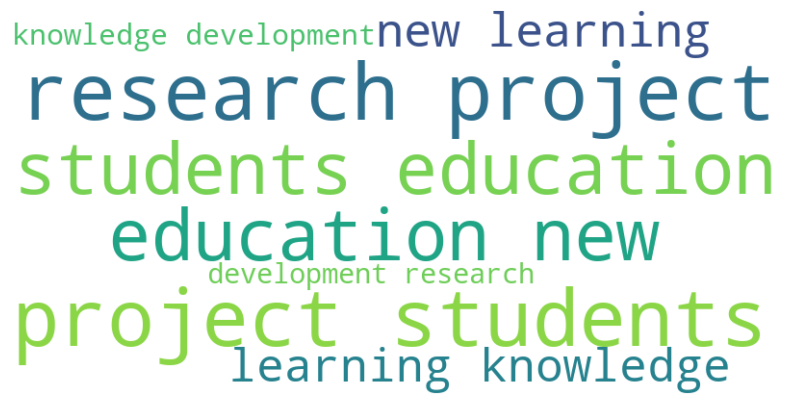

In [22]:
outlier_topic = df_projects[df_projects['Topic'] == -1]

words = ' '.join([' '.join(item) for item in outlier_topic['Representation']])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [23]:
SELECTED_TOPIC_ID = -1
TOPIC_INDEX = SELECTED_TOPIC_ID + 1
SELECTED_TOPIC_NAME = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]

topic_name = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
print_markdown(f'### This table shows the likelihood that projects belong to Topic ({SELECTED_TOPIC_ID}) {SELECTED_TOPIC_NAME}:')

if LOAD_MODEL:
    # Extract the probabilities for the specific topic
    specific_topic_probs = probs[:, TOPIC_INDEX]
else:
    # Extract the probabilities for the specific topic
    specific_topic_probs = probs[:, SELECTED_TOPIC_ID]

# Find the indices of documents with a probability above the threshold for the specific topic
doc_indices = np.where(specific_topic_probs >= 0.3)[0]

# Retrieve the documents with the specific topic
docs_with_specific_topic = [docs[i] for i in doc_indices]

# Create a DataFrame with the documents and their probabilities for the specific topic
df_specific_topic = pd.DataFrame({
    'document': docs_with_specific_topic,
    'probability': specific_topic_probs[doc_indices]
})

# Sort the DataFrame in descending order by probability
df_specific_topic = df_specific_topic.sort_values(by='probability', ascending=False).reset_index(drop=True)

df_specific_topic['probability'] = df_specific_topic['probability'].round(2)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # None means all data will be displayed in one line
pd.set_option('display.max_colwidth', 500)  # None means all data will be displayed without truncation

display(df_specific_topic.head(5))

# Create a DataFrame with the top 10 documents and their probabilities for the specific topic
df_specific_topic_top_n = df_specific_topic.head(10)

# Truncate the 'document' column to 100 characters
df_specific_topic_top_n['document'] = df_specific_topic_top_n['document'].str.slice(0, 140)

# Create a bar chart
fig = go.Figure(data=[
    go.Bar(
        y=df_specific_topic_top_n.index,
        x=df_specific_topic_top_n['probability'],
        text=df_specific_topic_top_n['document'],
        textposition='inside',
        insidetextanchor='end',  # Align text to the right
        orientation='h',  # horizontal bar chart
        marker_color='skyblue'
    )
])

# Add title and labels
fig.update_layout(
    title_text=f'Projects sorted on probability for Topic {SELECTED_TOPIC_ID} ({SELECTED_TOPIC_NAME})',
    xaxis_title=f'Probability of matching to topic {SELECTED_TOPIC_ID}',
    yaxis_title='Projects',
    yaxis_autorange="reversed"  # Invert y-axis to have the highest probability at the top
)

# Show the plot
fig.show()

### This table shows the likelihood that projects belong to Topic (-1) Outlier Topic:

,document,probability
0,making the netherlands futureproof through digital maps and minecraft the choices we as humanity make over the next ten years will determine our future the netherlands faces major challenges the energy transition sustainability of agriculture restoration of biodiversity urbanization and climate adaptation all these tasks have consequences for spatial planning organization of our country the ipcc report provides a scientific substantiation of the changes taking place at a global level a numbe...,0.70
1,sustainable development goals voor inclusieve mondiale ontwikkeling we propose to organize a series of professionally moderated online cocreation sessions as developed by the new resilientsociety platform to refine nwa route s research agenda for dutch knowledge institutes to work on in the period in this project we will capture the dutch midterm sdg development agenda for low and middle income countries and translate this into an actionable collaborative research agenda,0.70
2,organising knowledge and learning for the regional energy transition orakle in the context of the dutch climate agreement and the need to meet the targets radical change of the system supporting societal needs for energy is required also referred to as energy transition to better understand the dynamics and to facilitate the change in practice transition research is undertaken while municipalities and provinces are experimenting with tools facilitating bottomup innovation processes many less...,0.69
3,governing global goals uniting knowledge and perspectives on the sdgs for inclusive development interventions to realise one of the sustainable development goals sdgs might affect the pursuit of another in various ways interventions can have i separate effects ii contradictions and conflicts iii consecutive effects andor iv spillover and synergies to better understand such interactions and contribute to policies that promote synergies the dutch research council nwo initiated the sustainable ...,0.69
4,sustainable development goals voor inclusieve mondiale ontwikkeling one of the most important projects the route team is working on is the realization of the fast forward academy ffa together with partners in africa this will be collaboration for joint learning on how to collaborate trans disciplinary and cocreate across countries and cultures in order to address sdgs in africa while at the same time strengthening each others institutes and creating long term collaborations based on mutual t...,0.67


## **TRANSFORM QUERY AND ASSIGN CLOSEST CLUSTER** <a class="anchor" id="query_assign"></a>

These are the topics related to your query. Your query is firstly embedded, and then used to calculate the cosine similarity with each topic representation. The top $n$ topics are then shown. The number of topics shown can be changed at the top of the notebook.

In [24]:
print_markdown(f"### Input query:\n##### {QUERY[0]}")

similar_topics, similarity = topic_model.find_topics(QUERY[0], top_n=TOPIC_COUNT)
print_markdown(f"### Topics found (numbers):\n##### {similar_topics}\n")
TOPICS = [topic for topic in similar_topics if len(df_projects[df_projects['Topic'] == topic]) >= MIN_PROJECTS_CLUSTER]

print_markdown("### Topics, ranked top to bottom, match with query:\n")
topics_list = []
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")

print_markdown_list(topics_list)

### Input query:
##### sustainability industry innovation process technology innovation raw materials circularity consumption goods

### Topics found (numbers):
##### [38, 86, 161, 246, 230, 254, 34, 139]


### Topics, ranked top to bottom, match with query:


- ##### (38): Circular Economy Transition Strategies
- ##### (86): Sustainable Cleantech Innovation Model
- ##### (161): Sustainable Packaging Solutions
- ##### (246): Sustainable Waste Management Initiatives
- ##### (230): Circular Cotton Recycling Systems
- ##### (254): Sustainable Urban Renewal Approaches
- ##### (34): Thermoset Composite Reuse Research
- ##### (139): Sustainable Fashion Industry Exploration


#### **ASSIGNED TOPICS WORDCLOUD** <a class="anchor" id="topic_worldcloud"></a>

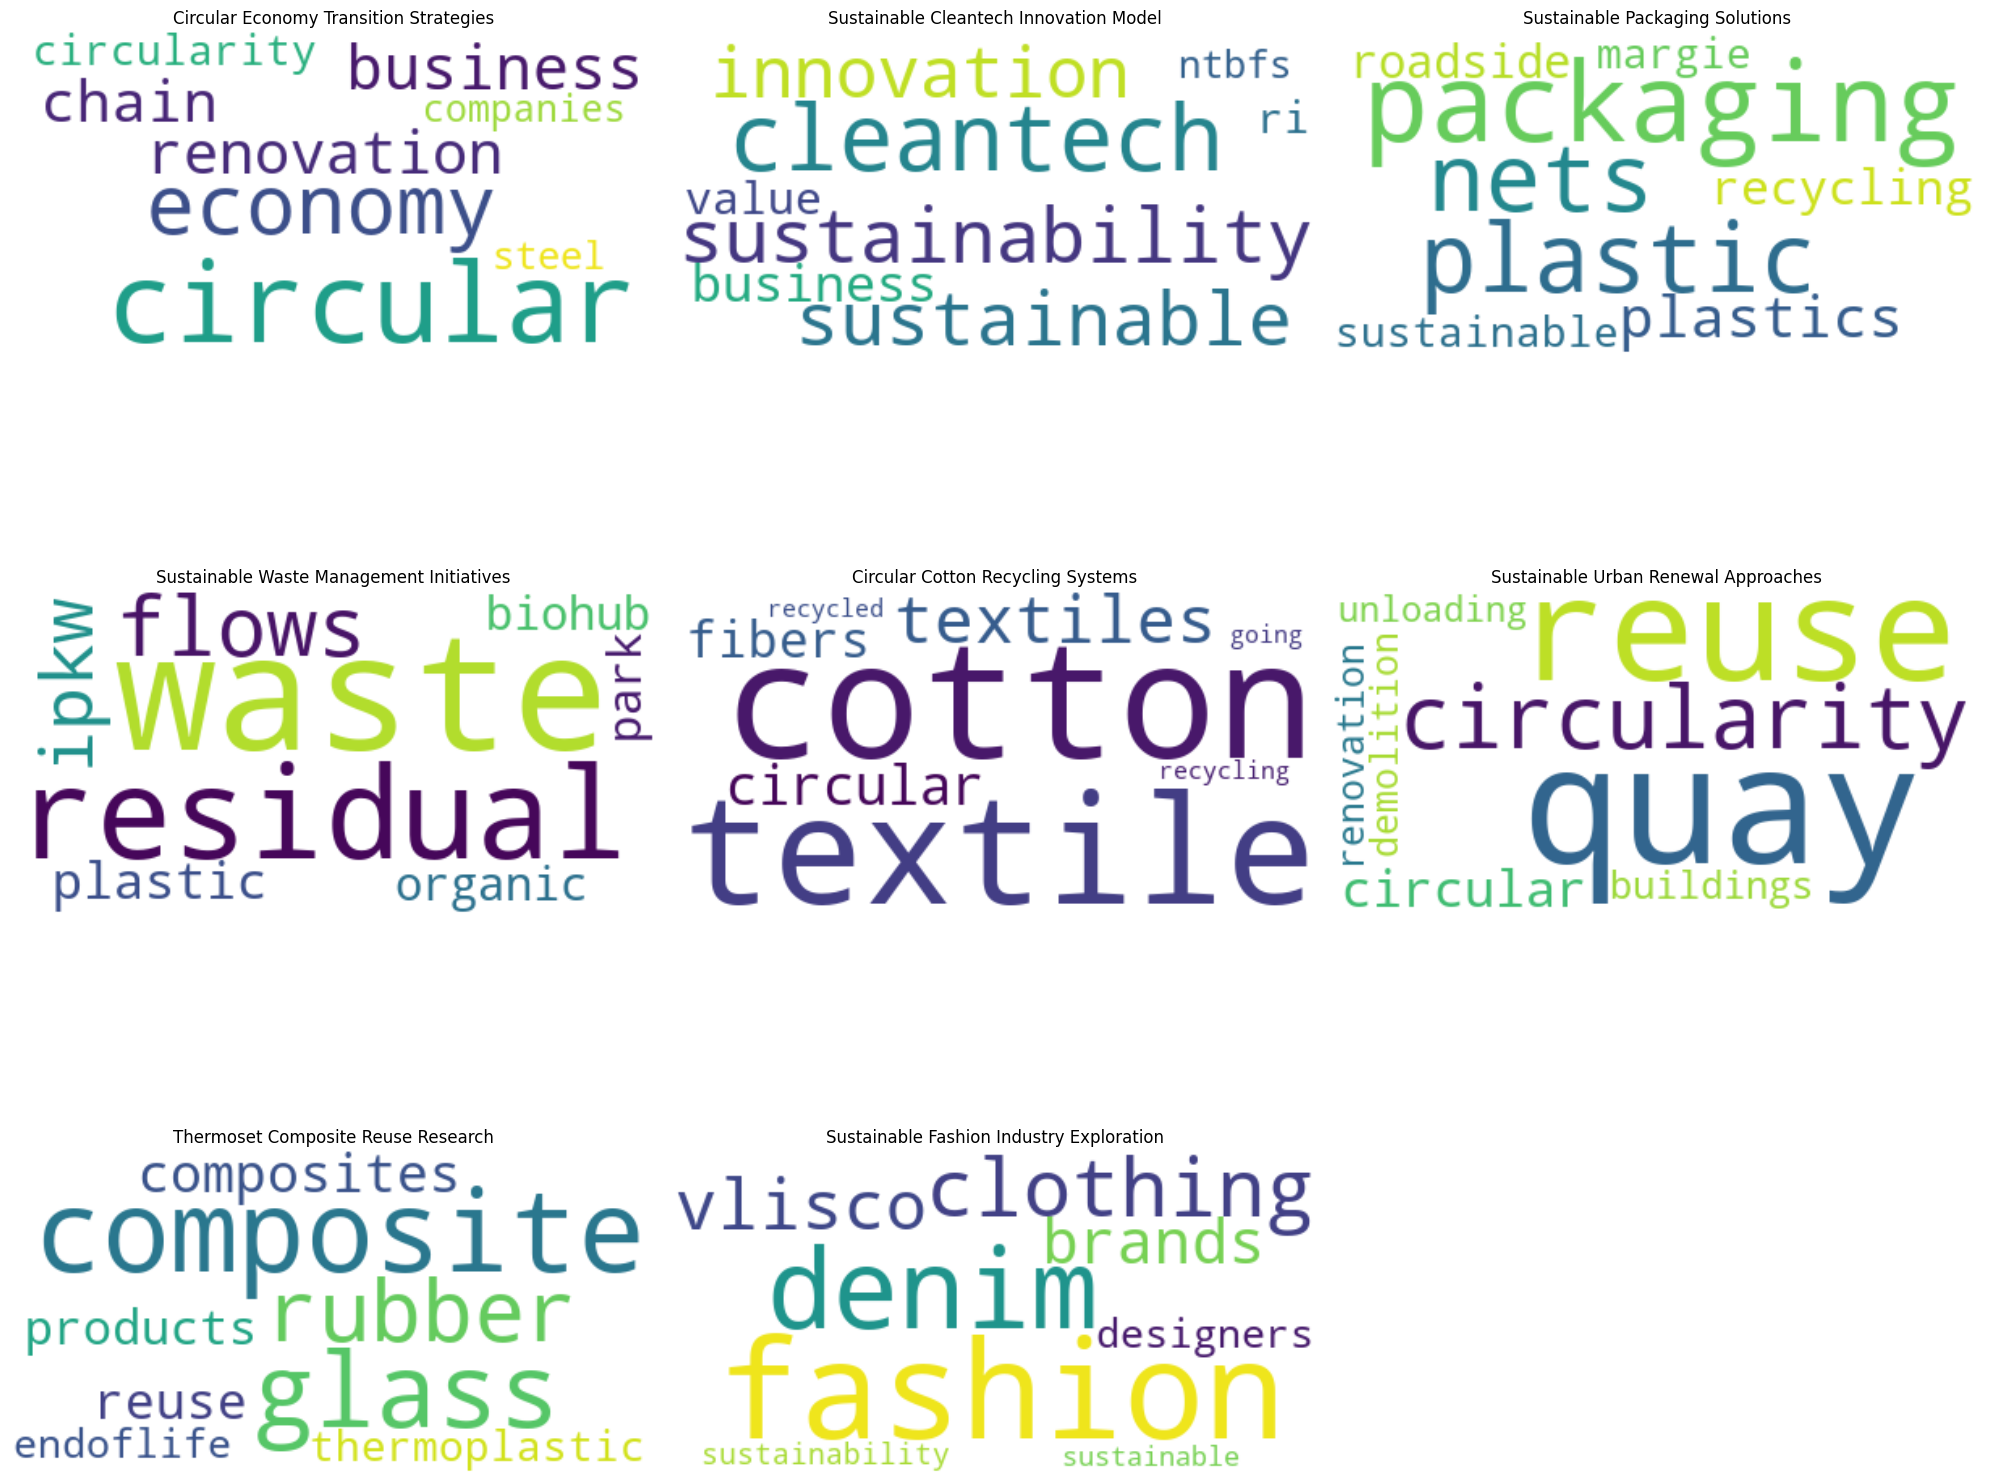

In [25]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    return wc.generate_from_frequencies(text)

# generate and plot each word cloud
cols = 3  # maximum three plots per row
rows = (len(TOPICS) + cols - 1) // cols  # calculate the number of rows needed
plt.figure(figsize=(20, 6 * rows))  # adjust figure size as needed

for index, topic in enumerate(TOPICS):
    plt.subplot(rows, cols, index + 1)  # create a subplot for each topic
    wc = create_wordcloud(topic_model, topic=topic)
    
    # retrieve the custom name for the topic
    topic_projects = df_projects[df_projects['Topic'] == topic]
    if not topic_projects.empty:
        title = topic_projects['CustomName'].iloc[0]
    else:
        title = f"Topic {topic}"
    
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

## **VIZUALIZATIONS FOR ONE SPECIFIC TOPIC** <a class="anchor" id="visual_one"></a>

How to use: Choose a single topic you want to visualize, pick one number from the topics that where assigned to your query. By default this will be the topic that best matched your query. The topics found are listed here again below:

In [26]:
print_markdown("### Topics, ranked top to bottom, match with query:\n")
topics_list = []
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")

print_markdown_list(topics_list)

### Topics, ranked top to bottom, match with query:


- ##### (38): Circular Economy Transition Strategies
- ##### (86): Sustainable Cleantech Innovation Model
- ##### (161): Sustainable Packaging Solutions
- ##### (246): Sustainable Waste Management Initiatives
- ##### (230): Circular Cotton Recycling Systems
- ##### (254): Sustainable Urban Renewal Approaches
- ##### (34): Thermoset Composite Reuse Research
- ##### (139): Sustainable Fashion Industry Exploration


##### <font color='red'>**SELECT**</font><br>

In [27]:
SELECTED_TOPIC_ID = TOPICS[0] # choose topic for visualizations, default is best match with query (the top one). Example input: SELECTED_TOPIC_ID = 35

In [28]:
TOPIC_INDEX = SELECTED_TOPIC_ID + 1
SELECTED_TOPIC_NAME = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
print_markdown(f'### Selected topic is: ({SELECTED_TOPIC_ID}): {SELECTED_TOPIC_NAME}')

### Selected topic is: (38): Circular Economy Transition Strategies

#### **PROJECTS IN TOPIC** <a class="anchor" id="projects_topic"></a>

##### <font color='red'>**PARAMETER**</font>

In [29]:
THRESHOLD_DOC_PROB_TABLE = 0.1  # Adjust the threshold based on your needs, docs below the trehshold will not be shown

In [30]:
topic_name = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
print_markdown(f'### This table shows the likelihood that projects belong to Topic ({SELECTED_TOPIC_ID}) {SELECTED_TOPIC_NAME}:')

if LOAD_MODEL:
    # Extract the probabilities for the specific topic
    specific_topic_probs = probs[:, TOPIC_INDEX]
else:
    # Extract the probabilities for the specific topic
    specific_topic_probs = probs[:, SELECTED_TOPIC_ID]

# Find the indices of documents with a probability above the threshold for the specific topic
doc_indices = np.where(specific_topic_probs >= THRESHOLD_DOC_PROB_TABLE)[0]

# Retrieve the documents with the specific topic
docs_with_specific_topic = [docs[i] for i in doc_indices]

# Create a DataFrame with the documents and their probabilities for the specific topic
df_specific_topic = pd.DataFrame({
    'document': docs_with_specific_topic,
    'probability': specific_topic_probs[doc_indices]
})

# Sort the DataFrame in descending order by probability
df_specific_topic = df_specific_topic.sort_values(by='probability', ascending=False).reset_index(drop=True)

df_specific_topic['probability'] = df_specific_topic['probability'].round(2)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)  # None means all data will be displayed in one line
pd.set_option('display.max_colwidth', 500)  # None means all data will be displayed without truncation

display(df_specific_topic.head(5))

# Create a DataFrame with the top 10 documents and their probabilities for the specific topic
df_specific_topic_top_n = df_specific_topic.head(10)

# Truncate the 'document' column to 100 characters
df_specific_topic_top_n['document'] = df_specific_topic_top_n['document'].str.slice(0, 140)

# Create a bar chart
fig = go.Figure(data=[
    go.Bar(
        y=df_specific_topic_top_n.index,
        x=df_specific_topic_top_n['probability'],
        text=df_specific_topic_top_n['document'],
        textposition='inside',
        insidetextanchor='end',  # Align text to the right
        orientation='h',  # horizontal bar chart
        marker_color='skyblue'
    )
])

# Add title and labels
fig.update_layout(
    title_text=f'Projects sorted on probability for Topic {SELECTED_TOPIC_ID} ({SELECTED_TOPIC_NAME})',
    xaxis_title=f'Probability of matching to topic {SELECTED_TOPIC_ID}',
    yaxis_title='Projects',
    yaxis_autorange="reversed"  # Invert y-axis to have the highest probability at the top
)

# Show the plot
fig.show()

### This table shows the likelihood that projects belong to Topic (38) Circular Economy Transition Strategies:

,document,probability
0,circular building installations an important issue that we as a society must answer is what to do if raw materials are no longer available because our raw material supply is finite the right answer is that we solve it by closing cycles and realizing a circular economy but how do we do that at the moment we do not yet know what a circular economy should ideally look like there is a lot of talk and writing about it but there is still too little attention for the application of circular process...,0.87
1,circular business and human capital in limburg the netherlands wants to be completely circular focusing on the optimal use and reuse of raw materials and energy in the various links of the production chain opportunities will arise for circular business operations and this is not just about innovative technology added value is also collaboration of the various actors within value chains in a circular society support from companies regional stakeholders and consumers for circular thinking and ...,0.85
2,circular entrepreneurship from concept to practice to keep our economy sustainably resilient we must make haste with the circular economy concept in a circular economy raw materials and products remain in circulation for as long as possible and are used as optimally as possible during their life cycle the transition towards a circular economy potentially offers great opportunities for smes such as access to new markets innovative power futureproofing and opportunities for new partnerships in...,0.85
3,circular building material this research contributes to the transition to a circular economy in the construction sector the dutch construction sector is resource intensive at the same time a large amount of demolition waste is produced this material could partly be reused as a building material but supply and demand for circular building material are not yet connected the transition to a circular construction economy requires stronger collaboration between chain partners and changes in the b...,0.83
4,circular economy in hospitality building a networked learning community committed to develop further knowledge on the application of circular economy in the hospitality industry circular economy is a novel disruptive paradigm redefining sustainability in the hospitality industry and addressing the environmental challenges set by this fastgrowing impactful industry to address these challenges the creation of further knowledge on circular economy and its applications in the hospitality sector ...,0.80


##### <font color='red'>**SELECT**</font><br>

In [31]:
# SELECTED_PROJECT_ID refers to the IDs shown in the figure above which is based relative to your selected topic (this is not the original project ID)
SELECTED_PROJECT_ID = 0

In [32]:
document_text = df_specific_topic['document'][SELECTED_PROJECT_ID]

document_text = textwrap.fill(document_text, width=200)
print_markdown(document_text)

circular building installations an important issue that we as a society must answer is what to do if raw materials are no longer available because our raw material supply is finite the right answer is
that we solve it by closing cycles and realizing a circular economy but how do we do that at the moment we do not yet know what a circular economy should ideally look like there is a lot of talk and
writing about it but there is still too little attention for the application of circular processes in practice and especially in construction and installation sector which is often called a
conservative sector circular applications are still early in the innovation adoption curve and this sector in particular is a huge consumer of materials and raw materials the installations in a
building are of great importance when renovating buildings it accounts for no less than of the total contract price relates to installations large profits can therefore be achieved when applying
circular principles the circular economy offers opportunities here the development of a number of knowledge products helps the partners in this research project to discover and take steps in the field
of a circular economy and offers opportunities for the sector as a whole this research contributes to the realization of the circular economy through the development of various knowledge products
these knowledge products are developed based on a relevant practical case in the chain education research business the utrecht model the practical case can be found in the largescale renovation the
university of applied sciences has commissioned the renovation of two buildings in its own buildings this collaboration concerns the buildings of the utrecht university of applied sciences on the
padualaan and in utrecht when tendering for this renovation no explicit request was made about making the university circular renovation but towards sustainability and energysaving measures utrecht
university of applied sciences has been the most sustainable university of applied sciences in the netherlands for three years in a row according to students of tomorrow who see this renovation as an
opportunity to also contribute to knowledge about circular processes and circular possibilities for future renovations

#### **RELATED TOPICS** <a class="anchor" id="topic_related"></a>

In [33]:
# Extract the topic embeddings
topic_embeddings = topic_model.topic_embeddings_

# Get the embedding of the specific topic
specific_topic_embedding = topic_embeddings[TOPIC_INDEX].reshape(1, -1)

# Compute the cosine similarity between the specific topic and all other topics
similarities = cosine_similarity(specific_topic_embedding, topic_embeddings).flatten()

# Convert similarities to distances (1 - similarity)
distances = 1 - similarities

# Round distances to 2 decimal places
distances = np.round(distances, 2)

# Sort the distances and get the corresponding topic indices
sorted_indices = np.argsort(distances)

# Show results
topic_info = topic_model.get_topic_info().loc[sorted_indices].iloc[:, :5]

# Rename the 'Count' column to 'document_count'
topic_info.rename(columns={'Count': 'document_count'}, inplace=True)

# Add the distances to the DataFrame
topic_info['distance'] = distances[sorted_indices]

print_markdown(f'### This table shows a list of topics that are closest to topic {SELECTED_TOPIC_ID} using cosine similarity:')

# Display the updated DataFrame
display(topic_info.head(10))

### This table shows a list of topics that are closest to topic 38 using cosine similarity:

,Topic,document_count,Name,CustomName,Representation,distance
39,38,49,38_circular_economy_business_renovation,Circular Economy Transition Strategies,"[circular, economy, business, renovation, chain, circularity, steel, companies]",0.00
255,254,10,254_quay_reuse_circularity_circular,Sustainable Urban Renewal Approaches,"[quay, reuse, circularity, circular, buildings, demolition, renovation, unloading]",0.25
87,86,30,86_cleantech_sustainability_sustainable_innovation,Sustainable Cleantech Innovation Model,"[cleantech, sustainability, sustainable, innovation, business, value, ri, ntbfs]",0.25
155,154,20,154_wood_waste_circular_hva,Innovative Wood Upcycling Solutions,"[wood, waste, circular, hva, arena, chairs, construction, upcycling]",0.30
247,246,11,246_waste_residual_flows_ipkw,Sustainable Waste Management Initiatives,"[waste, residual, flows, ipkw, plastic, organic, biohub, park]",0.31
45,44,45,44_logistics_blockchain_chain_supply,Urban Service Logistics Study,"[logistics, blockchain, chain, supply, customs, service, sector, smes]",0.33
290,289,9,289_innovation_commons_openresearchamsterdam_scripts,Collaborative Innovation Initiatives,"[innovation, commons, openresearchamsterdam, scripts, partnership, open, megosu, source]",0.35
70,69,35,69_food_agriculture_circular_dairy,Circular Dairy Farming Transition,"[food, agriculture, circular, dairy, farming, agricultural, farmers, transition]",0.35
32,31,51,31_energy_transition_residents_regional,Socially Just Energy Transition,"[energy, transition, residents, regional, participation, gas, renewable, poverty]",0.36
105,104,26,104_enterprises_social_innovation_smes,Social Enterprise Scaling Strategies,"[enterprises, social, innovation, smes, labor, scaling, entrepreneurs, entrepreneurship]",0.38


##### <font color='red'>**PARAMETER**</font>

In [34]:
# Set minimal distance (cosine similarity) fo find closest related topics
MIN_DISTANCE = 0.3

In [35]:
# show other topics that are closest related
closest_topics = topic_info[topic_info['distance'] < MIN_DISTANCE]['Topic']
title_barchart = f'Topics with cosine distance < {MIN_DISTANCE} with Topic {SELECTED_TOPIC_ID} ({SELECTED_TOPIC_NAME})'
topic_model.visualize_barchart(title=title_barchart, topics=closest_topics, n_words=15, custom_labels=True, width=450, height=300)

## **VIZUALIZATIONS FOR MULTIPLE TOPICS** <a class="anchor" id="visual_multiple"></a>

Choose multiple topics you want to visualize, in python list format. By default this will be the all the topics. The topics matched with your query are listed here again below:

In [36]:
print_markdown("### Topics, ranked top to bottom, match with query:\n")
topics_list = []
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")

print_markdown_list(topics_list)

### Topics, ranked top to bottom, match with query:


- ##### (38): Circular Economy Transition Strategies
- ##### (86): Sustainable Cleantech Innovation Model
- ##### (161): Sustainable Packaging Solutions
- ##### (246): Sustainable Waste Management Initiatives
- ##### (230): Circular Cotton Recycling Systems
- ##### (254): Sustainable Urban Renewal Approaches
- ##### (34): Thermoset Composite Reuse Research
- ##### (139): Sustainable Fashion Industry Exploration


##### <font color='red'>**SELECT**</font> AND <font color='red'>**PARAMETER**</font><br>

In [37]:
# Choose your topic IDs:
SELECTED_TOPIC_IDS = TOPICS[:6]

# visualizations
START_YEAR = 2015  # start year for generating visualizations
END_YEAR = 2023  # end year for generating visualizations

In [38]:
print_markdown('### The selected topics are:')
topics_list = []
for topic_id in SELECTED_TOPIC_IDS:
    TOPIC_INDEX = topic_id + 1
    SELECTED_TOPIC_NAME = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
    topics_list.append(f'({topic_id}): {SELECTED_TOPIC_NAME}')
    
print_markdown_list(topics_list)

### The selected topics are:

- ##### (38): Circular Economy Transition Strategies
- ##### (86): Sustainable Cleantech Innovation Model
- ##### (161): Sustainable Packaging Solutions
- ##### (246): Sustainable Waste Management Initiatives
- ##### (230): Circular Cotton Recycling Systems
- ##### (254): Sustainable Urban Renewal Approaches


#### **PROJECT COUNT OVER TIME** <a class="anchor" id="project_count"></a>

In [39]:
# Convert 'start_date' to datetime format
df_projects['start_date'] = pd.to_datetime(df_projects['start_date'])

# Filter data
filtered_data = df_projects[(df_projects['start_date'].dt.year >= START_YEAR) &
                            (df_projects['start_date'].dt.year <= END_YEAR) &
                            (df_projects['Topic'].isin(TOPICS))]

# Group data by year and topic
grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, 'Topic'])['project_id'].count().unstack(fill_value=0)

# Ensure all years are included in the index
all_years = pd.Index(range(START_YEAR, END_YEAR + 1), name='Year')
grouped_data = grouped_data.reindex(all_years, fill_value=0)

# Create the line plot
line_fig = go.Figure()

# Get cluster representations for topic labels
topic_data = filtered_data.drop_duplicates(subset=['Topic'])

for topic in SELECTED_TOPIC_IDS:
    if topic in grouped_data.columns:
        representation = topic_data.loc[topic_data['Topic'] == topic, 'CustomName'].iloc[0]
        if isinstance(representation, list):
            representation = ', '.join(representation)
        
        # Adding trace to line plot
        line_fig.add_trace(go.Scatter(
            x=grouped_data.index,
            y=grouped_data[topic],
            name=representation,
            mode='lines+markers'
        ))

# Update layout for the line plot
line_fig.update_layout(
    title='Project Count by Topic Over Time (Line Plot)',
    xaxis_title='Year',
    yaxis_title='Number of Projects',
    legend_title='CustomName'
)

# Show the line plot
line_fig.show()

In [40]:
# Filter data
filtered_data = df_projects[(df_projects['start_date'].dt.year >= START_YEAR) &
                            (df_projects['start_date'].dt.year <= END_YEAR) &
                            (df_projects['Topic'].isin(TOPICS))]

df_cleaned_projects = filtered_data[filtered_data['CustomName'] != 'Outlier Topic']
df_cleaned_projects = df_cleaned_projects[df_cleaned_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

# Parse start_date to extract year
df_cleaned_projects['year'] = pd.to_datetime(df_cleaned_projects['start_date']).dt.year

# Find the top 25 topics by frequency
top_25_topics = df_cleaned_projects['CustomName'].value_counts().head(25).index.tolist()

# Filter DataFrame to only include top 25 topics
df_top_topics = df_cleaned_projects[df_cleaned_projects['CustomName'].isin(top_25_topics)]

# Create a pivot table to count the frequency of topics per year
heatmap_data = pd.pivot_table(df_top_topics, values='project_id', index='CustomName', columns='year', aggfunc='count', fill_value=0)

# Create a custom colorscale
colorscale = [[0, 'rgb(255,255,255)'], [1, 'rgba(99,110,251,255)']]

# Create heatmap
fig = go.Figure(data=go.Heatmap(
                   z=heatmap_data.values,
                   x=heatmap_data.columns,
                   y=heatmap_data.index,
                   colorscale=colorscale,
                   zmin=0, zmax=heatmap_data.values.max(),
                   text=heatmap_data.values,
                   texttemplate='%{text}',
                   textfont={"size":10}
               ))

fig.update_layout(
    title='Heatmap of Selected Topic Frequencies by Year',
    xaxis_nticks=len(heatmap_data.columns),
    yaxis_nticks=len(heatmap_data.index),
    xaxis_title="Year",
    yaxis_title="Topic"
)

fig.show()

#### **DEPARTMENTS** <a class="anchor" id="departments"></a>

In [41]:
# Function to wrap text
def wrap_text(text, width=25):
    return '<br>'.join(textwrap.wrap(text, width=width))

In [42]:
# Function to wrap text
def wrap_text(text, width=25):
    return '<br>'.join(textwrap.wrap(text, width=width))

# Convert 'start_date' to datetime format
df_projects['start_date'] = pd.to_datetime(df_projects['start_date'])

# Filter data
filtered_data = df_projects[(df_projects['start_date'].dt.year >= START_YEAR) &
                            (df_projects['start_date'].dt.year <= END_YEAR) &
                            (df_projects['Topic'].isin(TOPICS))]

# Group data by year and topic
grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, 'Topic'])['project_id'].count().unstack(fill_value=0)

# Ensure all years are included in the index
all_years = pd.Index(range(START_YEAR, END_YEAR + 1), name='Year')
grouped_data = grouped_data.reindex(all_years, fill_value=0)

# Filter the dataframe for the specified topic IDs
filtered_topics = df_projects[df_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

# Count the frequency of topics per department for the specified topics
topic_counts = filtered_topics.groupby(['department', 'Topic']).size().reset_index(name='Frequency')

# Get the unique topics for the specified TOPIC_IDS
unique_topics = filtered_topics['Topic'].unique()

# Get the custom names for the specified TOPIC_IDS
custom_names = [wrap_text(df_projects[df_projects['Topic'] == topic]['CustomName'].iloc[0]) for topic in unique_topics]

# Create a subplot layout with 1 row and the number of columns equal to the number of unique topics
fig = make_subplots(rows=1, cols=len(unique_topics), shared_yaxes=True, subplot_titles=custom_names)

# Add traces for the specified topics
for i, topic in enumerate(unique_topics, start=1):
    topic_data = topic_counts[topic_counts['Topic'] == topic]
    wrapped_departments = [wrap_text(department) for department in topic_data['department']]
    wrapped_departments[0] = 'Meerdere'
    fig.add_trace(go.Bar(
        y=wrapped_departments,
        x=topic_data['Frequency'],
        name=f"{topic}",
        orientation='h'
    ), row=1, col=i)

# Update layout
fig.update_layout(
    title="Departments per Topic",
    xaxis_title="Frequency",
    yaxis_title="Department",
    showlegend=False,
    height=600
)

fig.show()

#### **SUB-DEPARTMENTS** <a class="anchor" id="sub_departments"></a>

In [43]:
# Function to wrap text
def wrap_text(text, width=25):
    return '<br>'.join(textwrap.wrap(text, width=width))

# Filter the dataframe for the specified topic IDs
filtered_topics = df_projects[df_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

# Count the frequency of topics per department for the specified topics
topic_counts = filtered_topics.groupby(['sub_department', 'Topic']).size().reset_index(name='Frequency')

# Get the unique topics for the specified TOPIC_IDS
unique_topics = filtered_topics['Topic'].unique()

# Get the custom names for the specified TOPIC_IDS
custom_names = [wrap_text(df_projects[df_projects['Topic'] == topic]['CustomName'].iloc[0]) for topic in unique_topics]

# Create a subplot layout with 1 row and the number of columns equal to the number of unique topics
fig = make_subplots(rows=1, cols=len(unique_topics), shared_yaxes=True, subplot_titles=custom_names)

# Add traces for the specified topics
for i, topic in enumerate(unique_topics, start=1):
    topic_data = topic_counts[topic_counts['Topic'] == topic]
    wrapped_departments = [wrap_text(department) for department in topic_data['sub_department']]
    fig.add_trace(go.Bar(
        y=wrapped_departments,
        x=topic_data['Frequency'],
        name=f"{topic}",
        orientation='h'
    ), row=1, col=i)

# Update layout
fig.update_layout(
    title="Sub departments per Topic",
    xaxis_title="Frequency",
    yaxis_title="Sub department",
    showlegend=False,
    height=600
)

fig.show()

#### **FUNDING SCHEMES** <a class="anchor" id="funding"></a>

In [44]:
def plot_top_n_schemes(df, column_name, start_year, end_year, top_n, max_characters, selected_topic_ids, values_to_exclude):
    # Convert 'start_date' to datetime format
    df['start_date'] = pd.to_datetime(df['start_date'])
    
    # Add truncated column
    truncated_column = f'truncated_{column_name}'
    df[truncated_column] = df[column_name].str[:max_characters]
    
    # Filter data
    filtered_data = df[
        (df['start_date'].dt.year >= start_year) &
        (df['start_date'].dt.year <= end_year) &
        (df['Topic'].isin(selected_topic_ids)) &
        (~df[column_name].isin(values_to_exclude))
    ]
    
    # Group data by year and truncated column
    grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, truncated_column])['project_id'].count().unstack(fill_value=0)
    
    # Ensure all years are included in the index
    all_years = pd.Index(range(start_year, end_year + 1), name='Year')
    grouped_data = grouped_data.reindex(all_years, fill_value=0)
    
    # Calculate total counts for each truncated scheme
    total_counts = grouped_data.sum(axis=0)
    
    # Get the top N truncated schemes by count
    top_n_schemes = total_counts.nlargest(top_n).index
    
    # Filter the grouped data to include only the top N truncated schemes
    grouped_data = grouped_data[top_n_schemes]
    
    # Create the line plot
    line_fig = go.Figure()
    
    for scheme in top_n_schemes:
        if scheme in grouped_data.columns:
            # Adding trace to line plot
            line_fig.add_trace(go.Scatter(
                x=grouped_data.index,
                y=grouped_data[scheme],
                name=scheme,
                mode='lines+markers'
            ))
    
    # Update layout for the line plot
    line_fig.update_layout(
        title=f'Project Count by Top {top_n} {column_name} (Truncated to {max_characters} Characters) Over Time (Line Plot)',
        xaxis_title='Year',
        yaxis_title='Number of Projects',
        legend_title=column_name
    )
    
    # Show the line plot
    line_fig.show()


plot_top_n_schemes(
    df=df_projects,
    column_name='funding_scheme',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=7,
    max_characters=4, # truncate funding scheme names to get data grouped on a relevant level
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)


plot_top_n_schemes(
    df=df_projects,
    column_name='department',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)

plot_top_n_schemes(
    df=df_projects,
    column_name='department',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=['']  # remove empty values
)

plot_top_n_schemes(
    df=df_projects,
    column_name='sub_department',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)

#### **FUNDING SCHEMES IN DEPTH** <a class="anchor" id="funding_depth"></a>

##### <font color='red'>**PARAMETER**</font>

In [45]:
FUNDING_COUNT_THRESHOLD = 3 # adjust the threshold for the funcing schemes, funding schemes below the threshold will not be shown

In [46]:
# Filter the dataframe for the specified topic IDs
filtered_topics = df_projects[df_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

# Count the frequency of funding schemes
funding_counts = filtered_topics.groupby('funding_scheme').size().reset_index(name='Frequency')

# Apply the funding count threshold filter
funding_counts = funding_counts[funding_counts['Frequency'] >= FUNDING_COUNT_THRESHOLD]

# Sort the funding counts in descending order
funding_counts = funding_counts.sort_values(by='Frequency', ascending=False)

# Prepare data for the bar chart
funding_counts['Funding Scheme'] = funding_counts['funding_scheme']

# Create the horizontal bar chart
fig = go.Figure(data=[go.Bar(
    y=funding_counts['Funding Scheme'],
    x=funding_counts['Frequency'],
    orientation='h'
)])

# Update layout
fig.update_layout(
    title=f"Funding Schemes for selected Topics:{SELECTED_TOPIC_IDS}",
    xaxis_title="Frequency",
    yaxis_title="Funding Scheme",
    height=600
)

fig.show()

##### <font color='red'>**PARAMETER**</font>

In [47]:
MAX_CHARACTERS_FUNDING = 4 # truncate the names of the funding schemes to n characters

In [48]:
# Function to truncate text
def truncate_text(text, max_length):
    return text if len(text) <= max_length else text[:max_length]

# Filter the dataframe for the specified topic IDs
filtered_topics = df_projects[df_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

# Count the frequency of funding schemes
funding_counts = filtered_topics.groupby('funding_scheme').size().reset_index(name='Frequency')

# Sort the funding counts in descending order
funding_counts = funding_counts.sort_values(by='Frequency', ascending=False)

# Prepare data for the bar chart
funding_counts['Funding Scheme'] = funding_counts['funding_scheme'].apply(lambda x: truncate_text(x, MAX_CHARACTERS_FUNDING))

# Sort the Funding Scheme column to maintain order in the bar chart
funding_counts = funding_counts.sort_values(by='Frequency', ascending=False)

# Create the horizontal bar chart
fig = go.Figure(data=[go.Bar(
    y=funding_counts['Funding Scheme'],
    x=funding_counts['Frequency'],
    orientation='h'
)])

# Update layout
fig.update_layout(
    title=f"Funding Schemes, where the funding scheme name is grouped using max characters: {MAX_CHARACTERS_FUNDING}",
    xaxis_title="Frequency",
    yaxis_title="Funding Scheme",
    height=600
)

fig.show()

##### <font color='red'>**PARAMETER**</font>

In [49]:
MAX_CHARACTERS = 4 # truncate the name of the funding schemes to n characters
TOP_N_FUNDINGSCHEMES = 12 # select the n top funding schemes in the dataset

In [50]:
filtered_topics = df_projects[df_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

filtered_topics_ = filtered_topics.copy()

# Step 1: Truncate funding scheme names
filtered_topics_ = filtered_topics_[filtered_topics_['funding_scheme'] != 'Outlier Topic']
filtered_topics_['funding_scheme_truncated'] = filtered_topics_['funding_scheme'].str.slice(0, MAX_CHARACTERS)

# Step 1: Identify the top 12 funding schemes
top_funding_schemes = filtered_topics_['funding_scheme_truncated'].value_counts().head(TOP_N_FUNDINGSCHEMES).index.tolist()

# Step 2: Create a subplot grid with 6 rows and 2 columns
fig = make_subplots(rows=6, cols=2, subplot_titles=top_funding_schemes)

# Map topics to their representative words
topic_labels = {topic: ''.join(words) for topic, words in topic_model.get_topic_info().set_index('Topic')['CustomName'].to_dict().items()}

# Function to create a bar chart for a given funding scheme
def add_bar_chart(fig, funding_scheme, row, col):
    # Filter the topic_counts DataFrame for the specified funding_scheme
    filtered_topic_counts = filtered_topics_[filtered_topics_['funding_scheme_truncated'] == funding_scheme]

    # Count the frequency of topics for the specified funding_scheme
    topic_counts = filtered_topic_counts['Topic'].value_counts().reset_index().head(15)
    topic_counts.columns = ['Topic', 'Frequency']

    # Sort values by frequency
    topic_counts = topic_counts.sort_values(by='Frequency', ascending=True)

    # Add bar trace
    fig.add_trace(go.Bar(
        y=[topic_labels[topic] for topic in topic_counts['Topic']],
        x=topic_counts['Frequency'],
        orientation='h'
    ), row=row, col=col)

# Step 3: Iterate over the top funding schemes and add a bar chart for each
for idx, funding_scheme in enumerate(top_funding_schemes):
    row = (idx // 2) + 1
    col = (idx % 2) + 1
    add_bar_chart(fig, funding_scheme, row, col)

# Update layout
fig.update_layout(
    height=1800,  # Adjust height to fit 6 rows
    width=2000,
    title_text="Topics for Top 12 Funding Schemes",
    showlegend=False  # Hide the legend to avoid clutter
)

fig.show()

##### <font color='red'>**PARAMETER**</font>

In [51]:
MAX_CHARACTERS = 4 # truncate the name of the funding schemes to n characters
TOP_N_FUNDINGSCHEMES = 12 # select the n top funding schemes in the dataset

In [52]:
filtered_topics = df_projects[df_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

# Remove topics with CustomName 'Outlier Topic'
df_cleaned_projects = filtered_topics[filtered_topics['CustomName'] != 'Outlier Topic']

# Truncate funding scheme names
df_cleaned_projects['funding_scheme_truncated'] = df_cleaned_projects['funding_scheme'].str.slice(0, MAX_CHARACTERS)

# Find the top funding schemes
top_funding_schemes = df_cleaned_projects['funding_scheme_truncated'].value_counts().head(TOP_N_FUNDINGSCHEMES).index.tolist()

# Filter DataFrame to only include top funding schemes
df_top_funding_schemes = df_cleaned_projects[df_cleaned_projects['funding_scheme_truncated'].isin(top_funding_schemes)]

# Find the top 25 topics by frequency
top_25_topics = df_top_funding_schemes['CustomName'].value_counts().head(25).index.tolist()

# Filter DataFrame to only include top 25 topics
df_top_topics = df_top_funding_schemes[df_top_funding_schemes['CustomName'].isin(top_25_topics)]

# Create a pivot table to count the frequency of topics per funding scheme
heatmap_data = pd.pivot_table(df_top_topics, values='project_id', index='CustomName', columns='funding_scheme_truncated', aggfunc='count', fill_value=0)

# Create a custom colorscale
colorscale = [[0, 'rgb(255,255,255)'], [1, 'rgba(99,110,251,255)']]

# Create heatmap
fig = go.Figure(data=go.Heatmap(
                   z=heatmap_data.values,
                   x=heatmap_data.columns,
                   y=heatmap_data.index,
                   colorscale=colorscale,
                   zmin=0, zmax=heatmap_data.values.max(),
                   text=heatmap_data.values,
                   texttemplate='%{text}',
                   textfont={"size":10}
               ))

fig.update_layout(
    title='Heatmap of Topic Frequencies by Top Funding Schemes',
    xaxis_nticks=len(heatmap_data.columns),
    yaxis_nticks=len(heatmap_data.index),
    xaxis_title="Funding Scheme",
    yaxis_title="Topic"
)

fig.show()

## **COMPARING TWO TOPICS** <a class="anchor" id="compare"></a>

If you want to compare to different topics you can input two different queries here.

##### <font color='red'>**SELECT**</font><br>

In [53]:
QUERY_1 = ['sustainability industry innovation process technology innovation raw materials circularity consumption goods']
QUERY_2 = ["ai artifical intelligence"]

In [54]:

print_markdown(f"### Input query 1:\n##### '{QUERY_1[0]}'\n")
print_markdown(f"### Input query 2:\n##### '{QUERY_2[0]}'\n")

similar_topics_1, similarity_1 = topic_model.find_topics(QUERY_1[0], top_n=TOPIC_COUNT)
print_markdown(f"### Topics found (numbers):\n##### {similar_topics_1}\n")
TOPICS_1 = [topic for topic in similar_topics_1 if len(df_projects[df_projects['Topic'] == topic]) >= MIN_PROJECTS_CLUSTER]
similar_topics_2, similarity_2 = topic_model.find_topics(QUERY_2[0], top_n=TOPIC_COUNT)
print_markdown(f"### Topics found (numbers):\n##### {similar_topics_2}\n")
TOPICS_2 = [topic for topic in similar_topics_2 if len(df_projects[df_projects['Topic'] == topic]) >= MIN_PROJECTS_CLUSTER]

print_markdown("### Topics, ranked top to bottom, match with query 1:")
topics_list = []
for i in TOPICS_1:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")
print_markdown_list(topics_list)
            
print_markdown("\n ### Topics, ranked top to bottom, match with query 2:")
topics_list = []
for i in TOPICS_2:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")
print_markdown_list(topics_list)

### Input query 1:
##### 'sustainability industry innovation process technology innovation raw materials circularity consumption goods'


### Input query 2:
##### 'ai artifical intelligence'


### Topics found (numbers):
##### [38, 86, 161, 246, 230, 254, 34, 139]


### Topics found (numbers):
##### [94, 219, 82, 194, 203, 243, 157, 272]


### Topics, ranked top to bottom, match with query 1:

- ##### (38): Circular Economy Transition Strategies
- ##### (86): Sustainable Cleantech Innovation Model
- ##### (161): Sustainable Packaging Solutions
- ##### (246): Sustainable Waste Management Initiatives
- ##### (230): Circular Cotton Recycling Systems
- ##### (254): Sustainable Urban Renewal Approaches
- ##### (34): Thermoset Composite Reuse Research
- ##### (139): Sustainable Fashion Industry Exploration



 ### Topics, ranked top to bottom, match with query 2:

- ##### (94): Responsible Applied AI
- ##### (219): Collaborative AI in Medical Decisions
- ##### (82): Robots in Workplace Settings
- ##### (194): Human-Guided Data Science
- ##### (203): Empathetic chatbots for mental health
- ##### (243): Neuromorphic Computing Hardware Development
- ##### (157): Gifted Education Impact Analysis
- ##### (272): Dynamics in Logical Reasoning


##### <font color='red'>**SELECT**</font><br>

In [55]:
# select topics you want to compare, you can use list slicing or simply write the lists out: e.g. TOPICS_1 = [35, 36, 37]
TOPICS_1_SELECT = TOPICS_1[:3]
TOPICS_2_SELECT =TOPICS_2[:3]

TOPICS_COMPARE = TOPICS_1_SELECT + TOPICS_2_SELECT

In [56]:
# Convert 'start_date' to datetime format
df_projects['start_date'] = pd.to_datetime(df_projects['start_date'])

# Filter data based on date and topic selection
filtered_data = df_projects[(df_projects['start_date'].dt.year >= START_YEAR) &
                            (df_projects['start_date'].dt.year <= END_YEAR) &
                            (df_projects['Topic'].isin(TOPICS_COMPARE))]

# Group data by year and topic
grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, 'Topic'])['project_id'].count().unstack(fill_value=0)

# Ensure all years are included in the index
all_years = pd.Index(range(START_YEAR, END_YEAR + 1), name='Year')
grouped_data = grouped_data.reindex(all_years, fill_value=0)

# Create the line plot
line_fig = go.Figure()

# Get cluster representations for topic labels
topic_data = filtered_data.drop_duplicates(subset=['Topic'])

# Define colors for TOPICS_1 and TOPICS_2
colors = {topic: 'rgba(99,110,251,1)' for topic in TOPICS_1}
colors.update({topic: 'rgba(239,86,59,1)' for topic in TOPICS_2})

# Add trace for each topic
for topic in TOPICS_COMPARE:
    if topic in grouped_data.columns:
        representation = topic_data.loc[topic_data['Topic'] == topic, 'CustomName'].iloc[0]
        if isinstance(representation, list):
            representation = ', '.join(representation)
        
        line_fig.add_trace(go.Scatter(
            x=grouped_data.index,
            y=grouped_data[topic],
            name=representation,
            mode='lines+markers'
        ))

# Add aggregated lines for TOPICS_1 and TOPICS_2
grouped_data['TOPICS_1_SUM'] = grouped_data[TOPICS_1_SELECT].sum(axis=1)
grouped_data['TOPICS_2_SUM'] = grouped_data[TOPICS_2_SELECT].sum(axis=1)

line_fig.add_trace(go.Scatter(
    x=grouped_data.index,
    y=grouped_data['TOPICS_1_SUM'],
    name='Aggregate TOPICS_1',
    mode='lines',
    line=dict(color='rgba(0,200,200,1)', width=2, dash='dash')
))

line_fig.add_trace(go.Scatter(
    x=grouped_data.index,
    y=grouped_data['TOPICS_2_SUM'],
    name='Aggregate TOPICS_2',
    mode='lines',
    line=dict(color='rgba(200,0,200,1)', width=2, dash='dash')
))

# Update layout
line_fig.update_layout(
    title='Project Count by Topic Over Time (Line Plot)',
    xaxis_title='Year',
    yaxis_title='Number of Projects',
    legend_title='Topic'
)

# Define a function to update the visibility of traces
def update_visibility(trace_index, visibility):
    line_fig.data[trace_index].visible = visibility

# Define the buttons
buttons = [
    dict(
        label='Show Aggregate Lines',
        method='restyle',
        args=['visible', [True if i in [len(line_fig.data)-2, len(line_fig.data)-1] else False for i in range(len(line_fig.data))]]
    ),
    dict(
        label='Show Separate Lines',
        method='restyle',
        args=['visible', [True if i not in [len(line_fig.data)-2, len(line_fig.data)-1] else False for i in range(len(line_fig.data))]]
    )
]

# Update layout to include the buttons
line_fig.update_layout(
    updatemenus=[
        dict(
            type='buttons',
            showactive=True,
            buttons=buttons,
            x=1.35,  # x position of the buttons (1 is the far right of the plot)
            y=1.2,  # y position of the buttons (1 is the top of the plot)
            xanchor='right',  # 'auto', 'left', 'center' or 'right'
            yanchor='top',  # 'auto', 'top', 'middle' or 'bottom'
        )
    ]
)

# Show the line plot
line_fig.show()

In [57]:
# Function to wrap text
def wrap_text(text, width=25):
    return '<br>'.join(textwrap.wrap(text, width=width))

# Filter the dataframe for the specified topic IDs
filtered_topics = df_projects[df_projects['Topic'].isin(TOPICS_COMPARE)]

# Count the frequency of topics per department for the specified topics
topic_counts = filtered_topics.groupby(['department', 'Topic']).size().reset_index(name='Frequency')

# Get the unique topics for the specified TOPIC_IDS
unique_topics = filtered_topics['Topic'].unique()

# Get the custom names for the specified TOPIC_IDS
custom_names = [wrap_text(df_projects[df_projects['Topic'] == topic]['CustomName'].iloc[0]) for topic in unique_topics]

# Create a subplot layout with 1 row and the number of columns equal to the number of unique topics
fig = make_subplots(rows=1, cols=len(unique_topics), shared_yaxes=True, subplot_titles=custom_names)

# Define colors for TOPICS_1 and TOPICS_2
colors = {topic: 'rgba(99,110,251,255)' for topic in TOPICS_1}
colors.update({topic: 'rgba(239,86,59,255)' for topic in TOPICS_2})

# Add traces for the specified topics
for i, topic in enumerate(unique_topics, start=1):
    topic_data = topic_counts[topic_counts['Topic'] == topic]
    wrapped_departments = [wrap_text(department) for department in topic_data['department']]
    wrapped_departments[0] = 'Meerdere'
    fig.add_trace(go.Bar(
        y=wrapped_departments,
        x=topic_data['Frequency'],
        name=f"{topic}",
        orientation='h',
        marker=dict(color=colors[topic])  # Use the defined colors
    ), row=1, col=i)

# Update layout
fig.update_layout(
    title="Departments per Topic",
    xaxis_title="Frequency",
    yaxis_title="Department",
    showlegend=False,
    height=600
)

# Show the plot
fig.show()

In [58]:
# Function to wrap text
def wrap_text(text, width=25):
    return '<br>'.join(textwrap.wrap(text, width=width))

# Filter the dataframe for the specified topic IDs
filtered_topics = df_projects[df_projects['Topic'].isin(TOPICS_COMPARE)]

# Count the frequency of topics per sub_department for the specified topics
topic_counts = filtered_topics.groupby(['sub_department', 'Topic']).size().reset_index(name='Frequency')

# Get the unique topics for the specified TOPIC_IDS
unique_topics = filtered_topics['Topic'].unique()

# Get the custom names for the specified TOPIC_IDS
custom_names = [wrap_text(df_projects[df_projects['Topic'] == topic]['CustomName'].iloc[0]) for topic in unique_topics]

# Create a subplot layout with 1 row and the number of columns equal to the number of unique topics
fig = make_subplots(rows=1, cols=len(unique_topics), shared_yaxes=True, subplot_titles=custom_names)

# Define colors for TOPICS_1 and TOPICS_2
colors = {topic: 'rgba(99,110,251,255)' for topic in TOPICS_1}
colors.update({topic: 'rgba(239,86,59,255)' for topic in TOPICS_2})

# Add traces for the specified topics
for i, topic in enumerate(unique_topics, start=1):
    topic_data = topic_counts[topic_counts['Topic'] == topic]
    wrapped_sub_departments = [wrap_text(sub_department) for sub_department in topic_data['sub_department']]
    fig.add_trace(go.Bar(
        y=wrapped_sub_departments,
        x=topic_data['Frequency'],
        name=f"{topic}",
        orientation='h',
        marker=dict(color=colors[topic])  # Use the defined colors
    ), row=1, col=i)

# Update layout
fig.update_layout(
    title="Sub Departments per Topic",
    xaxis_title="Frequency",
    yaxis_title="Sub Department",
    showlegend=False,
    height=600
)

# Show the plot
fig.show()

## **DEEP DIVE INTO TOPIC** <a class="anchor" id="deep_dive"></a>

Run the topic analysis again on a specific topic, this will analyse all the projects in that topic and make new sub-topics. Choose a topic number from the previous acuired list, for convienve the topics are listed here again:

In [59]:
print_markdown("### Topics, ranked top to bottom, match with query:\n")
topics_list = []
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            topics_list.append(f"({i}): {topic_projects['CustomName'].iloc[0]}")

print_markdown_list(topics_list)

### Topics, ranked top to bottom, match with query:


- ##### (38): Circular Economy Transition Strategies
- ##### (86): Sustainable Cleantech Innovation Model
- ##### (161): Sustainable Packaging Solutions
- ##### (246): Sustainable Waste Management Initiatives
- ##### (230): Circular Cotton Recycling Systems
- ##### (254): Sustainable Urban Renewal Approaches
- ##### (34): Thermoset Composite Reuse Research
- ##### (139): Sustainable Fashion Industry Exploration


##### <font color='red'>**SELECT**</font><br>

In [60]:
TOPICS_ZOOM = TOPICS[:1] # choose topic number, by default it is best match. e.g.: TOPCIS_ZOOM = [28]

##### <font color='red'>**PARAMETER**</font>

In [61]:
# the number of words per topic that you want to be extracted. These words are most representative of the topic. Should be kept between 10-20.
N_WORDS_REPRESENTATION_ZOOM = 8
# the number of words you want in your topic representation. If you want 'Circular Economy' in your representations, set it to (1,2)
N_GRAM_RANGE_ZOOM = (1, 2)
# the minimum size of a topic. Lower means more topics, higher means less topics. This should be lower now because we are searching within a topic, which has a lot less projects.
MIN_TOPIC_SIZE_ZOOM = 4

In [62]:
df_projects_zoom = df_projects[df_projects['Topic'].isin(TOPICS_ZOOM)]
print(f'Data shape: {df_projects_zoom.shape}')
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 40)
display(df_projects_zoom.head(1))

docs_zoom = list(df_projects_zoom.text.values) # create stacked list of abstracts
embeddings_zoom = sentence_model.encode(docs_zoom, show_progress_bar=True)

vectorizer_model = CountVectorizer(stop_words="english")

topic_model_zoom = BERTopic(verbose=True, 
                    calculate_probabilities=True,
                    top_n_words=N_WORDS_REPRESENTATION_ZOOM,
                    n_gram_range=N_GRAM_RANGE_ZOOM,
                    min_topic_size=MIN_TOPIC_SIZE_ZOOM,
                    vectorizer_model=vectorizer_model,
                    representation_model=representation_model,
                    embedding_model=sentence_model)

topics_zoom, probs_zoom = topic_model_zoom.fit_transform(docs_zoom, embeddings_zoom)

# add chatgpt labels to the model
chatgpt_topic_labels_zoom = {topics_zoom: " | ".join(list(zip(*values))[0]) for topics_zoom, values in topic_model_zoom.topic_aspects_["OpenAI"].items()}
chatgpt_topic_labels_zoom[-1] = "Outlier Topic"
topic_model_zoom.set_topic_labels(chatgpt_topic_labels_zoom)

df_topic_info_zoom = topic_model_zoom.get_topic_info()

display(topic_model_zoom.get_topic_info().head(2))
display(topic_model_zoom.visualize_barchart(top_n_topics=8, n_words=10, custom_labels=True, width=400))

Data shape: (68, 23)


,project_id,parent_project_id,title,funding_scheme_id,funding_scheme,department,sub_department,start_date,end_date,summary_nl,summary_en,project_members,products,start_year,text,language,token_count,Topic,Representation,CustomName,truncated_funding_scheme,truncated_department,truncated_sub_department
1055,438-14-905,None,the practice of sustainable business...,1263,Duurzame Businessmodellen 2014 MaGW,Sociale en Geesteswetenschappen,Maatschappij- en Gedragswetenschappen,2015-04-01,2019-10-25T00:00:00,n the past few decades there has bee...,n the past few decades there has bee...,"[{'role': 'Co-applicant', 'member_id...","[{'title': 'beoogd: proefschrift', '...",2015,the practice of sustainable business...,en,285,38,"[circular, economy, business, renova...",Circular Economy Transition Strategies,Duur,Sociale en Geesteswetenschappen,Maatschappij- en Gedragswetenschappen


Batches: 100%|██████████| 3/3 [00:00<00:00,  5.67it/s]
2024-06-21 12:13:02,271 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-21 12:13:03,189 - BERTopic - Dimensionality - Completed ✓
2024-06-21 12:13:03,190 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-21 12:13:03,196 - BERTopic - Cluster - Completed ✓
2024-06-21 12:13:03,197 - BERTopic - Representation - Extracting topics from clusters using representation models.
  0%|          | 0/5 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
2024-06-21 12:13:06,664 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,CustomName,Representation,OpenAI,Representative_Docs
0,-1,22,-1_circular_furniture_street_business,Outlier Topic,"[circular, furniture, street, busine...",[Circular Building Material Transition],[circular building installations an ...
1,0,17,0_circular_research_economy_knowledge,Circular Economy Research Collaboration,"[circular, research, economy, knowle...",[Circular Economy Research Collabora...,[born circular research into ecosyst...


In [63]:
filtered_topics = df_projects[df_projects['Topic'].isin(TOPICS_ZOOM)]
filtered_topics_zoom = filtered_topics.copy()

filtered_topics_zoom['Topic_zoom'] = topics_zoom
display(df_projects.head(1))

filtered_topics_zoom['Topic_zoom'] = filtered_topics_zoom['Topic_zoom'].astype(int)

filtered_topics_zoom = pd.merge(filtered_topics_zoom, df_topic_info_zoom[['Topic', 'Representation', 'CustomName']], left_on='Topic_zoom', right_on='Topic', how='left')

display(filtered_topics_zoom.head(1))

,project_id,parent_project_id,title,funding_scheme_id,funding_scheme,department,sub_department,start_date,end_date,summary_nl,summary_en,project_members,products,start_year,text,language,token_count,Topic,Representation,CustomName,truncated_funding_scheme,truncated_department,truncated_sub_department
0,612.001.210,None,enhancing efficiency and expressiven...,2691,Vrije competitie Vrije competitie EW...,Exacte en Natuurwetenschappen,Exacte Wetenschappen,2014-08-01,2018-12-31T00:00:00,Coalgebraic coinduction generalises ...,coalgebraic coinduction generalises ...,"[{'role': 'Project leader', 'member_...",[{'title': 'Regular varieties of aut...,2014,enhancing efficiency and expressiven...,en,314,42,"[automata, verification, rewriting, ...",Formal Verification of Hardware,Vrij,Exacte en Natuurwetenschappen,Exacte Wetenschappen


,project_id,parent_project_id,title,funding_scheme_id,funding_scheme,department,sub_department,start_date,end_date,summary_nl,summary_en,project_members,products,start_year,text,language,token_count,Topic_x,Representation_x,CustomName_x,truncated_funding_scheme,truncated_department,truncated_sub_department,Topic_zoom,Topic_y,Representation_y,CustomName_y
0,438-14-905,None,the practice of sustainable business...,1263,Duurzame Businessmodellen 2014 MaGW,Sociale en Geesteswetenschappen,Maatschappij- en Gedragswetenschappen,2015-04-01,2019-10-25T00:00:00,n the past few decades there has bee...,n the past few decades there has bee...,"[{'role': 'Co-applicant', 'member_id...","[{'title': 'beoogd: proefschrift', '...",2015,the practice of sustainable business...,en,285,38,"[circular, economy, business, renova...",Circular Economy Transition Strategies,Duur,Sociale en Geesteswetenschappen,Maatschappij- en Gedragswetenschappen,1,1,"[circular, business, chain, economy,...",Circular Economy Business Models


In [64]:
# Convert 'start_date' to datetime format
filtered_topics_zoom['start_date'] = pd.to_datetime(filtered_topics_zoom['start_date'])

# Filter data
filtered_data = filtered_topics_zoom[(filtered_topics_zoom['start_date'].dt.year >= START_YEAR) &
                            (filtered_topics_zoom['start_date'].dt.year <= END_YEAR)]

# Group data by year and topic
grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, 'Topic_zoom'])['project_id'].count().unstack(fill_value=0)

# Ensure all years are included in the index
all_years = pd.Index(range(START_YEAR, END_YEAR + 1), name='Year')
grouped_data = grouped_data.reindex(all_years, fill_value=0)

# Create the line plot
line_fig = go.Figure()

# Get cluster representations for topic labels
topic_data = filtered_data.drop_duplicates(subset=['Topic_zoom'])

for topic in topic_data['Topic_zoom'].unique():
    if topic != -1:
        if topic in grouped_data.columns:
            representation = topic_data.loc[topic_data['Topic_zoom'] == topic, 'CustomName_y'].iloc[0]
            if isinstance(representation, list):
                representation = ', '.join(representation)
            
            # Adding trace to line plot
            line_fig.add_trace(go.Scatter(
                x=grouped_data.index,
                y=grouped_data[topic],
                name=representation,
                mode='lines+markers'
            ))

# Update layout for the line plot
line_fig.update_layout(
    title='Project Count by Topic Over Time (Line Plot)',
    xaxis_title='Year',
    yaxis_title='Number of Projects',
    legend_title='CustomName'
)

# Show the line plot
line_fig.show()

In [65]:
filtered_topics = filtered_topics_zoom

# Remove topics with CustomName 'Outlier Topic'
df_cleaned_projects = filtered_topics[filtered_topics['CustomName_y'] != 'Outlier Topic']

# Truncate funding scheme names
df_cleaned_projects['funding_scheme_truncated'] = df_cleaned_projects['funding_scheme'].str.slice(0, MAX_CHARACTERS)

# Find the top funding schemes
top_funding_schemes = df_cleaned_projects['funding_scheme_truncated'].value_counts().head(TOP_N_FUNDINGSCHEMES).index.tolist()

# Filter DataFrame to only include top funding schemes
df_top_funding_schemes = df_cleaned_projects[df_cleaned_projects['funding_scheme_truncated'].isin(top_funding_schemes)]

# Find the top 25 topics by frequency
top_25_topics = df_top_funding_schemes['CustomName_y'].value_counts().head(25).index.tolist()

# Filter DataFrame to only include top 25 topics
df_top_topics = df_top_funding_schemes[df_top_funding_schemes['CustomName_y'].isin(top_25_topics)]

# Create a pivot table to count the frequency of topics per funding scheme
heatmap_data = pd.pivot_table(df_top_topics, values='project_id', index='CustomName_y', columns='funding_scheme_truncated', aggfunc='count', fill_value=0)

# Create a custom colorscale
colorscale = [[0, 'rgb(255,255,255)'], [1, 'rgba(99,110,251,255)']]

# Create heatmap
fig = go.Figure(data=go.Heatmap(
                   z=heatmap_data.values,
                   x=heatmap_data.columns,
                   y=heatmap_data.index,
                   colorscale=colorscale,
                   zmin=0, zmax=heatmap_data.values.max(),
                   text=heatmap_data.values,
                   texttemplate='%{text}',
                   textfont={"size":10}
               ))

fig.update_layout(
    title='Heatmap of Topic Frequencies by Top Funding Schemes',
    xaxis_nticks=len(heatmap_data.columns),
    yaxis_nticks=len(heatmap_data.index),
    xaxis_title="Funding Scheme",
    yaxis_title="Topic"
)

fig.show()

## **NETWORK ANALYSIS** <a class="anchor" id="network_analysis"></a>

In [66]:
df = df_projects.copy()

##### <font color='red'>**SELECT**</font>

Here you can select for which topics you want to analyze the networks for. 

In [67]:
# Examples copied from earlier
# (38): Circular Economy Transition Strategies
# (86): Sustainable Cleantech Innovation Model
# (161): Sustainable Packaging Solutions
# (246): Sustainable Waste Management Initiatives
# (230): Circular Cotton Recycling Systems
# (254): Sustainable Urban Renewal Approaches
# (34): Thermoset Composite Reuse Research
# (139): Sustainable Fashion Industry Exploration
# (94): Responsible Applied AI

TOPIC = 38

##### <font color='red'>**PARAMETER**</font>

In [68]:
SEED = 808

## **PREPROCESS DATA** <a class="anchor" id="preprocess_data"></a>

In [69]:
# select subset of data to focus on defined topic
df_topic = df.loc[df['Topic'] == TOPIC]

# try this if you get error or NaNs
# df_topic['project_members'] = df_topic['project_members'].apply(eval)

# filter authors
new_df = pd.DataFrame()
for row in df_topic['project_members']:
    authors = []

    for dct in row:
        first_name = dct.get('first_name', '').strip()
        last_name = dct.get('last_name', '').strip()

        if first_name or last_name:
            authors.append(f"{first_name} {last_name}".strip())
    
    authors = list(set(authors))
    temp_df = pd.DataFrame({'authors': [authors]})
    new_df = pd.concat([new_df, temp_df], ignore_index=True)

    new_df['sub_department'] = df_topic['sub_department'].reset_index(drop=True)
    new_df['start_year'] = df_topic['start_year'].reset_index(drop=True)

new_df = new_df.sort_values(by='start_year').reset_index().drop(columns=['index'])
new_df.head()

,authors,sub_department,start_year
0,"[Marjolein Caniëls, Bart Vos, Petra ...",Maatschappij- en Gedragswetenschappen,2015
1,"[Serdar Türkeli, René Kemp]",Maatschappij- en Gedragswetenschappen,2015
2,[Jetta Wille],Nationaal Regieorgaan Praktijkgerich...,2015
3,"[Patrick Veenendaal, Erlijn Eweg]",Nationaal Regieorgaan Praktijkgerich...,2016
4,[Patrick Kuijken],Nationaal Regieorgaan Praktijkgerich...,2016


## **STATIC NETWORKS** <a class="anchor" id="static_networks"></a>

#### **AUTHOR CENTRALITY ANALYSIS** <a class="anchor" id="author_centrality_analysis"></a>

Degree Centrality:

- Definition: Measures the number of direct connections a node has. It's a simple count of how many edges are incident to a node.

- Interpretation: Nodes with high degree centrality are often influential due to their many direct connections, indicating they are well-connected within the network.

Eigenvector Centrality:

- Definition: Measures the influence of a node based on the quality and quantity of its connections. It not only considers the number of connections (like degree centrality) but also the centrality of the nodes it is connected to.

- Interpretation: Nodes with high eigenvector centrality are influential because they are connected to other influential nodes, indicating a higher overall impact within the network.

Betweenness Centrality:

- Definition: Measures the extent to which a node lies on the shortest paths between other nodes. It is a measure of a node's role in facilitating communication or information flow within the network.

- Interpretation: Nodes with high betweenness centrality act as bridges or gatekeepers, controlling the flow of information and connecting different parts of the network.

##### <font color='red'>**SELECT**</font>

Here you can select which centrality measure you want to analyze. Also, you can decide how many top influential actors to view. 

In [70]:
# 0 for degree centrality
# 1 for eigenvector centrality
# 2 for betweenness centrality
CENTRALITY_MEASURE = 0

##### <font color='red'>**PARAMETER**</font>

In [71]:
TOP_THRESHOLD = 50

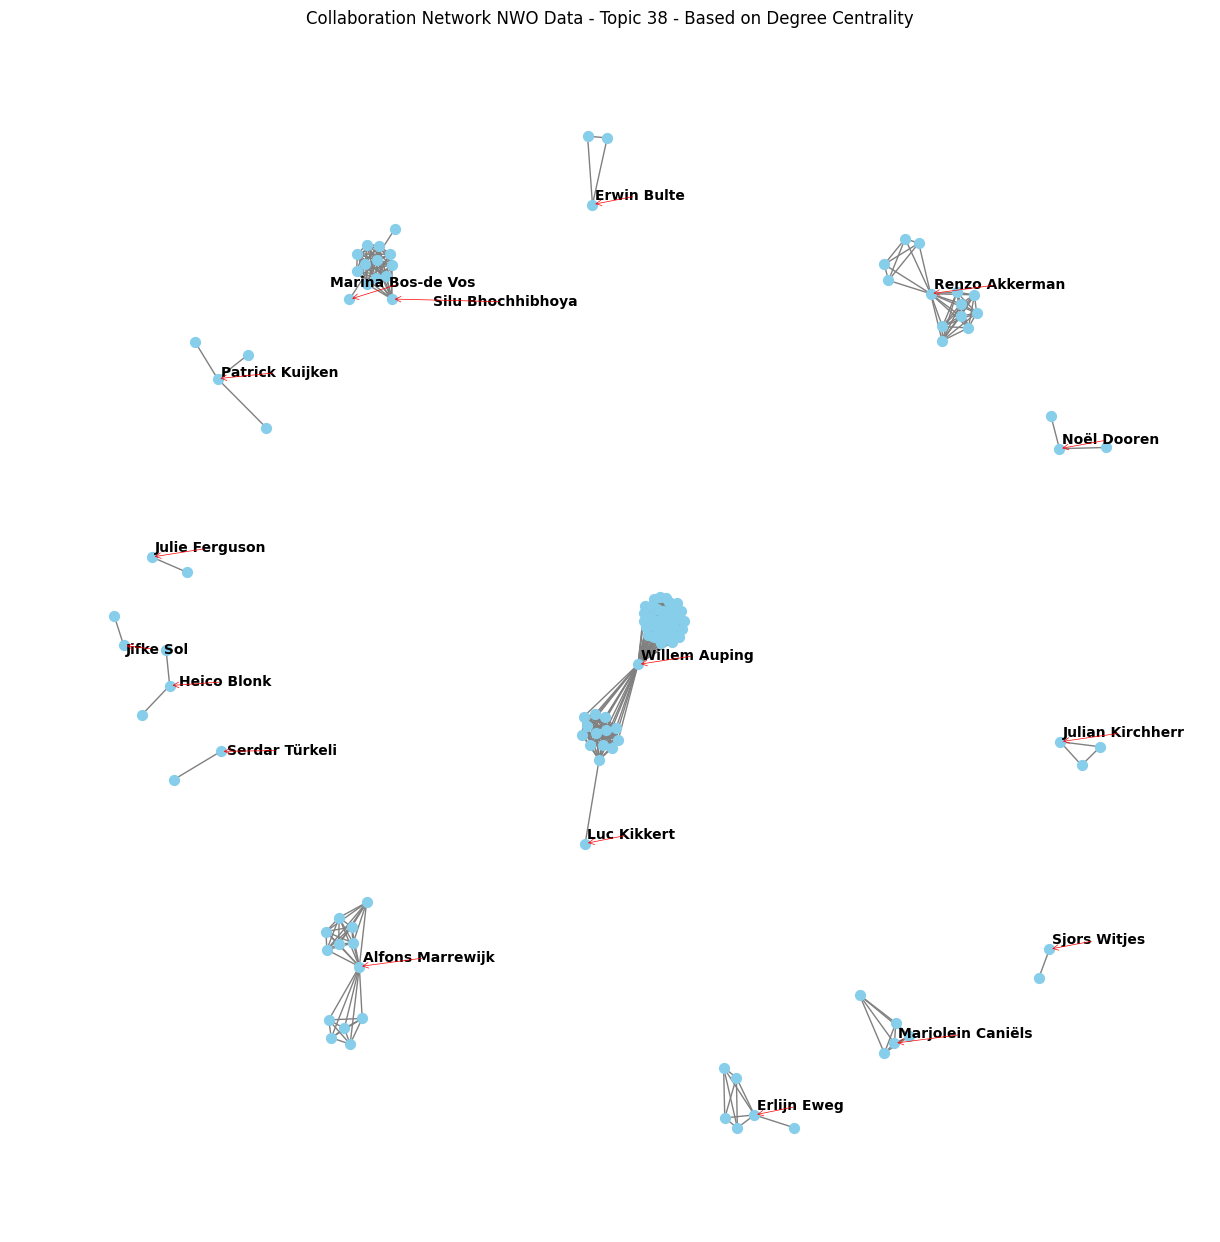

In [72]:
G = nx.Graph()

for authors in new_df['authors']:
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            G.add_edge(authors[i], authors[j])

communities = next(girvan_newman(G))
community_map = {node: idx for idx, community in enumerate(communities) for node in community}

# calculate degree centrality
if CENTRALITY_MEASURE == 0:
    centrality = nx.degree_centrality(G)
    centrality_label = 'Degree Centrality'
elif CENTRALITY_MEASURE == 1:
    centrality = nx.eigenvector_centrality(G)
    centrality_label = 'Eigenvector Centrality'
elif CENTRALITY_MEASURE == 2:
    centrality = nx.betweenness_centrality(G)
    centrality_label = 'Betweenness Centrality'
else:
    raise ValueError('Please input an existing value denoting preferred centrality measure.')

most_influential_authors = {}

for community in communities:
    most_influential_author = max(community, key=lambda node: centrality[node])
    most_influential_authors[most_influential_author] = centrality[most_influential_author]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15, seed=SEED)
nx.draw(G, pos, with_labels=False, node_size=50, node_color="skyblue", edge_color="gray")

# makes the labels smaller and cleaner
texts = []

for author in most_influential_authors:
    x, y = pos[author]
    text = plt.text(x, y, author, fontsize=10, color='black', weight='bold')
    texts.append(text)

adjust_text(texts)

# add arrows
for i, author in enumerate(most_influential_authors):
    text = texts[i]
    x, y = pos[author]
    plt.annotate(
    "", xy=(x, y), xytext=(text.get_position()[0], text.get_position()[1]),
    arrowprops={"arrowstyle": "->", "color": "red", "shrinkA": 5, "linewidth": 0.5}
    )

plt.title(f"Collaboration Network NWO Data - Topic {TOPIC} - Based on {centrality_label}")
plt.show()


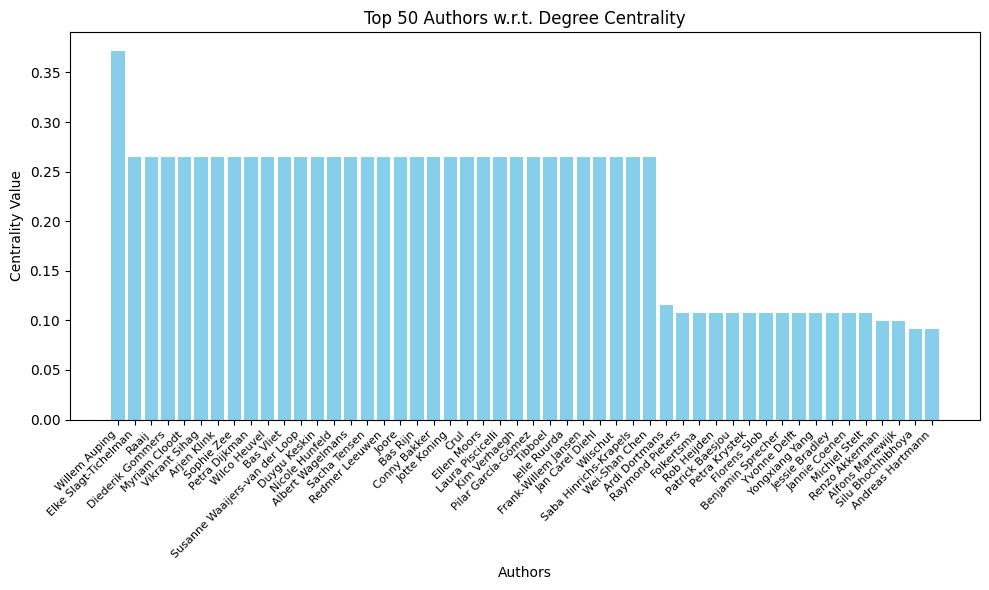

In [73]:
sorted_centrality_values = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
sorted_centrality_values = {author: value for author, value in sorted_centrality_values[:TOP_THRESHOLD]}

plt.figure(figsize=(10, 6))
plt.bar(sorted_centrality_values.keys(), sorted_centrality_values.values(), color='skyblue')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.xlabel('Authors')
plt.ylabel('Centrality Value')
plt.title(f'Top {TOP_THRESHOLD} Authors w.r.t. {centrality_label}')
plt.tight_layout()
plt.show()

#### **AUTHOR IN FOCUS** <a class="anchor" id="author_in_focus"></a>

##### <font color='red'>**SELECT**</font>

Some authors of interest can be analyzed further by looking at their connections.

In [74]:
AUTHOR_IN_FOCUS = 'Willem Auping'

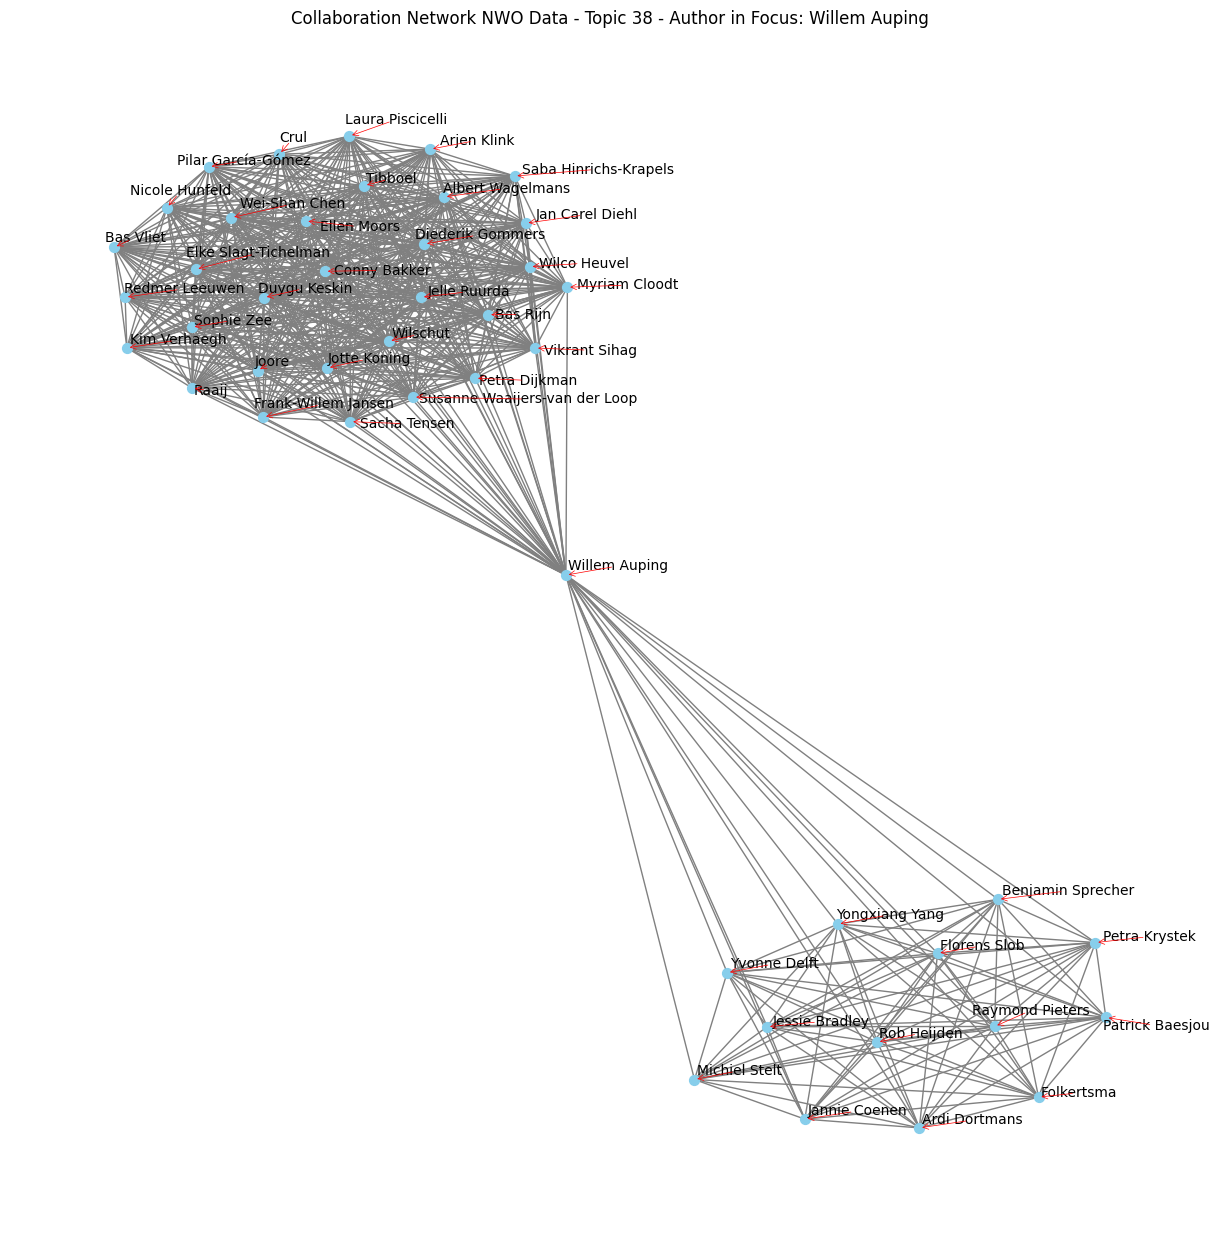

In [75]:
def plot_author_network(G, specific_author=None):
    if specific_author:
        neighbors = list(G.neighbors(specific_author)) + [specific_author]
        subG = G.subgraph(neighbors)
    else:
        subG = G

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(subG, k=0.15, seed=SEED)
    nx.draw(subG, pos, with_labels=False, node_size=50, node_color="skyblue", edge_color="gray")

    texts = []
    for author, (x, y) in pos.items():
        text = plt.text(x, y, author, fontsize=10, color='black')
        texts.append(text)
    adjust_text(texts)

    for i, (author, (x, y)) in enumerate(pos.items()):
        text = texts[i]
        plt.annotate(
            "", xy=(x, y), xytext=(text.get_position()[0], text.get_position()[1]),
            arrowprops={"arrowstyle": "->", "color": "red", "shrinkA": 5, "linewidth": 0.5}
        )

    plt.title(f"Collaboration Network NWO Data - Topic {TOPIC} - Author in Focus: {AUTHOR_IN_FOCUS}")
    plt.show()

plot_author_network(G, specific_author=AUTHOR_IN_FOCUS)

#### **AUTHORS AND DEPARTMENTS** <a class="anchor" id="authors_and_departments"></a>

This provides a general view of the actors and their respective departments. However, it also shows with the size of the bars which actors are influential or well-connected.

In [76]:
author_sub_department = {}

for idx, authors in enumerate(new_df['authors']):
    for author in authors:
        author_sub_department[author] = new_df['sub_department'][idx]

all_authors = list(set([author for authors in new_df['authors'] for author in authors]))
all_sub_departments = [author_sub_department[author] for author in all_authors]

all_nodes = list(set(all_authors + all_sub_departments))
node_labels = all_nodes

author_indices = [node_labels.index(author) for author in all_authors]
sub_department_indices = [node_labels.index(author_sub_department[author]) for author in all_authors]

centrality_values = [centrality.get(author, 0) for author in all_authors]

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_labels,
    ),
    link=dict(
        source=author_indices,
        target=sub_department_indices,
        value=centrality_values,
    )
)])

fig.update_layout(
    title_text="Sankey Diagram of Authors and Their Sub-Departments",
    font_size=10,
    height=1000,
    margin=dict(l=20, r=20, t=50, b=25)
)
fig.show()


#### **DEPARTMENT NETWORKS** <a class="anchor" id="department_networks"></a>

Here the potential interlinkages between departments are shown. For instance, authors that have worked in projects of different departments will cause a link between those departments to be created.

In [77]:
G = nx.Graph()

for index, row in new_df.iterrows():
    dept1 = row['authors']
    dept2 = row['sub_department']
    
    for person in dept1:
        G.add_edge(person, dept2)

degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

centrality_df = pd.DataFrame({
    'Department': list(degree_centrality.keys()),
    'Degree Centrality': list(degree_centrality.values()),
    'Betweenness Centrality': list(betweenness_centrality.values()),
    'Eigenvector Centrality': list(eigenvector_centrality.values())
})

influential_departments = centrality_df.sort_values(by='Degree Centrality', ascending=False)
influential_departments.head()

,Department,Degree Centrality,Betweenness Centrality,Eigenvector Centrality
46,Nationale Wetenschapsagenda,0.458065,0.395894,7.069649e-01
9,Nationaal Regieorgaan Praktijkgerich...,0.277419,0.075660,1.386595e-05
34,Sociale en Geesteswetenschappen,0.129032,0.219439,1.386133e-02
1,Maatschappij- en Gedragswetenschappen,0.077419,0.089401,2.348598e-04
41,WOTRO Science for Global Development,0.032258,0.000838,1.237250e-23


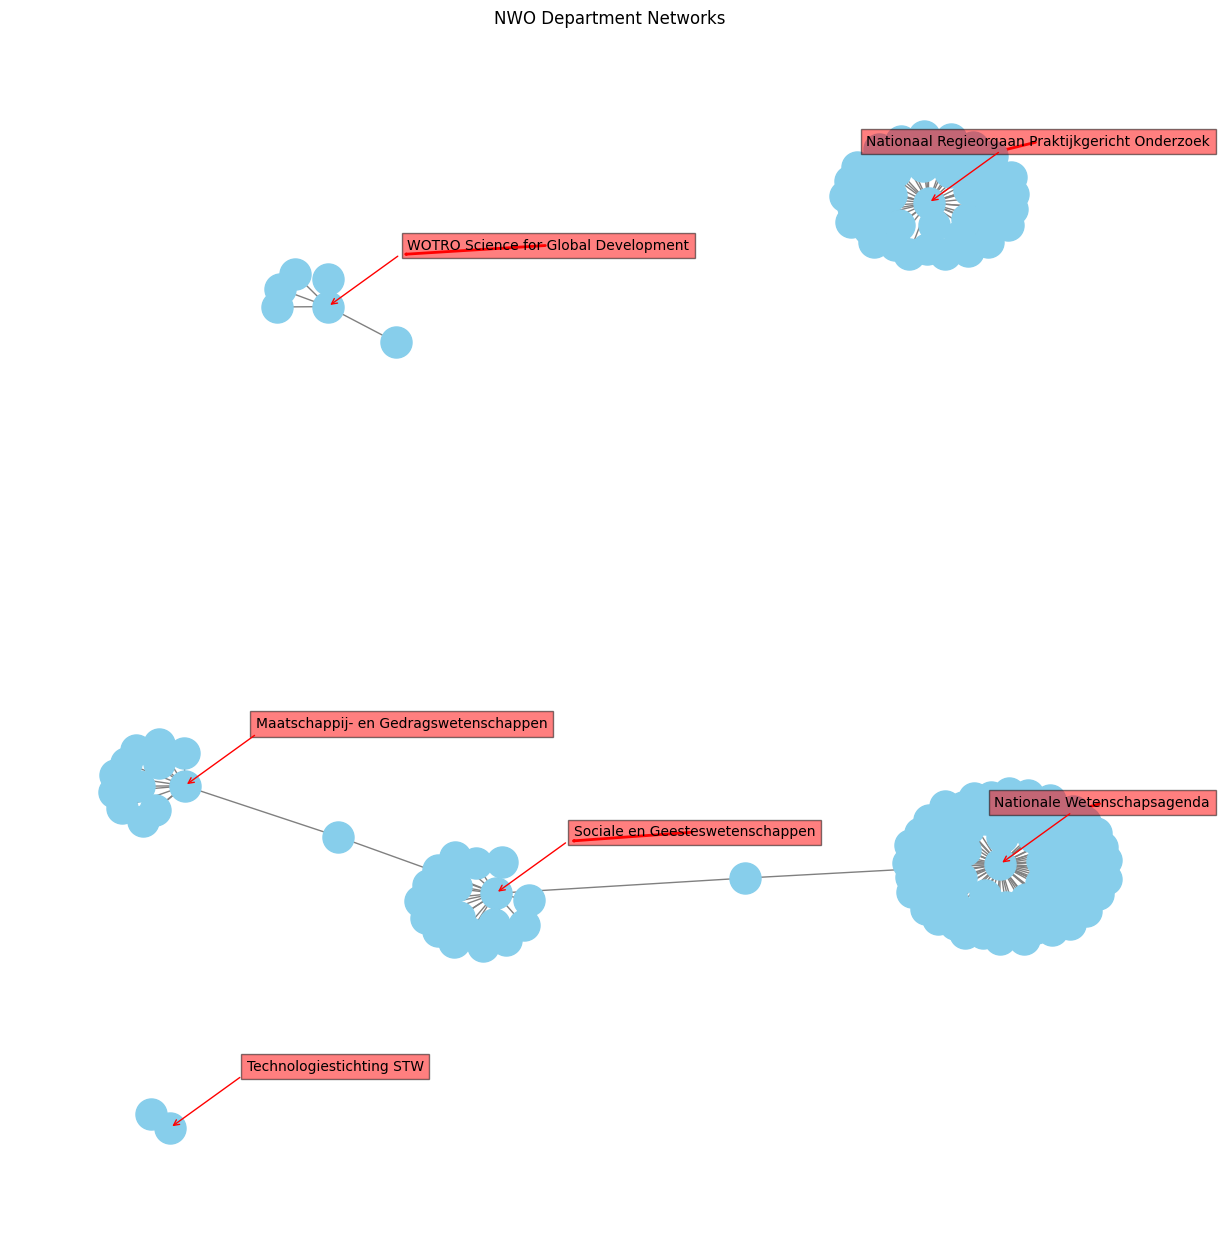

In [78]:
pos = nx.spring_layout(G, seed=SEED)

unconnected_nodes = [node for node in G.nodes() if G.degree(node) == 0]

if unconnected_nodes:
    min_x = min([pos[node][0] for node in pos])
    min_y = min([pos[node][1] for node in pos])

    offset_x = min_x - 1
    offset_y = min_y - 1

    for idx, node in enumerate(unconnected_nodes):
        pos[node] = (offset_x + 0.1 * idx, offset_y)

plt.figure(figsize=(12, 12))
nx.draw(G, pos, with_labels=False, node_size=500, node_color='skyblue', edge_color='gray')

def draw_labels_with_arrows(G, pos, nodes, color):
    texts = []

    for node in nodes:
        if node in pos:
            x, y = pos[node]
            offset = 0.10
            text = plt.text(x + offset, y + offset, s=node, bbox=dict(facecolor=color, alpha=0.5), horizontalalignment='left')
            texts.append(text)
            plt.annotate(
                "", xy=pos[node], xytext=(x + offset, y + offset),
                arrowprops=dict(arrowstyle="->", color=color, lw=1),
                textcoords='data'
            )
    adjust_text(texts, only_move={'texts': 'xy'}, arrowprops=dict(arrowstyle="->", color=color, lw=2))

departments = new_df['sub_department'].unique()
draw_labels_with_arrows(G, pos, departments, 'red')

plt.title("NWO Department Networks")
plt.show()

## **INTERACTIVE NETWORKS** <a class="anchor" id="interactive_networks"></a>

#### **AUTHOR NETWORKS OVER TIME** <a class="anchor" id="author_networks_over_time"></a>

This module shows an interactive network graph and it allows the user to use a slider to progress in time and see how the network evolves.

In [79]:
years = sorted(new_df['start_year'].unique())

all_authors = set()
all_edges = set()

G_all = nx.Graph()

for authors in new_df['authors']:
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            all_edges.add((authors[i], authors[j]))
    all_authors.update(authors)

G_all.add_edges_from(all_edges)
G_all.add_nodes_from(all_authors)

pos = nx.spring_layout(G_all, k=0.15, seed=SEED)

def create_graph_data(year, cumulative_authors, cumulative_edges):
    G = nx.Graph()
    df_year = new_df[new_df['start_year'] == year]
    
    for authors in df_year['authors']:
        for i in range(len(authors)):
            for j in range(i + 1, len(authors)):
                cumulative_edges.add((authors[i], authors[j]))
    
    G.add_edges_from(cumulative_edges)
    
    for authors in df_year['authors']:
        cumulative_authors.update(authors)
    
    G.add_nodes_from(cumulative_authors)
    
    edge_trace = go.Scatter(
        x=[], y=[],
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')
    
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])
    
    node_trace = go.Scatter(
        x=[], y=[],
        text=[],
        mode='markers',
        hoverinfo='text',
        hovertext=[],
        marker=dict(
            showscale=True,
            colorscale='Viridis',
            size=10,
            colorbar=dict(
                thickness=15,
                title='Centrality',
                xanchor='left',
                titleside='right'
            ),
            color=[]
        )
    )
    
    centrality = nx.degree_centrality(G)
    
    for node in G.nodes():
        x, y = pos[node]
        node_trace['x'] += tuple([x])
        node_trace['y'] += tuple([y])
        node_trace['hovertext'] += tuple([node])
        node_trace['marker']['color'] += tuple([centrality[node]])
    
    return edge_trace, node_trace, cumulative_authors, cumulative_edges

cumulative_authors = set()
cumulative_edges = set()

initial_year = years[0]
edge_trace, node_trace, cumulative_authors, cumulative_edges = create_graph_data(initial_year, cumulative_authors, cumulative_edges)

fig = go.Figure()
fig.add_trace(edge_trace)
fig.add_trace(node_trace)

steps = []
for year in years:
    edge_trace, node_trace, cumulative_authors, cumulative_edges = create_graph_data(year, cumulative_authors, cumulative_edges)
    steps.append(dict(
        args=[{'x': [edge_trace['x'], node_trace['x']],
               'y': [edge_trace['y'], node_trace['y']],
               'marker.color': [node_trace['marker']['color']],
               'text': [node_trace['hovertext']]}],
        label=str(year),
        method='update'
    ))

sliders = [dict(
    active=0,
    pad={"t": 50},
    steps=steps,
    x=0.1,
    xanchor='left',
    y=0,
    yanchor='top',
    currentvalue={'font': {'size': 20}, 'prefix': 'Year: ', 'visible': True, 'xanchor': 'right'}
)]

fig.update_layout(
    title=f"Collaboration Network NWO Data - Topic {TOPIC}",
    sliders=sliders,
    showlegend=False,
    height=800,
    margin=dict(l=20, r=20, t=40, b=20),
    xaxis=dict(showticklabels=False),
    yaxis=dict(showticklabels=False)
)

fig.show()



#### **MISCELLANEOUS - EXTENSIVE INTERACTIVE NETWORKS** <a class="anchor" id="misc_extensive_interactive_networks"></a>

Here are more interactive networks, which can function as a visual or interactive supplement to the static network analysis. It also has more capacity to scale larger. The output, however, is HTML and is usually run on the browser. 

##### <font color='red'>**SELECT**</font>

Here you can select which topic(s) should be included in the sample data. The authors of those topics will be shown in the network graph.

In [80]:
# Examples copied from earlier
# (38): Circular Economy Transition Strategies
# (86): Sustainable Cleantech Innovation Model
# (161): Sustainable Packaging Solutions
# (246): Sustainable Waste Management Initiatives
# (230): Circular Cotton Recycling Systems
# (254): Sustainable Urban Renewal Approaches
# (34): Thermoset Composite Reuse Research
# (139): Sustainable Fashion Industry Exploration
# (94): Responsible Applied AI

# TOPICS = [38]
TOPICS = [38, 86, 161, 246, 230, 254, 34, 139]

In [81]:
# select subset of data to focus on defined topic
df_topic = df.loc[df['Topic'].isin(TOPICS)]

# try this if you get error or NaNs
# df_topic['project_members'] = df_topic['project_members'].apply(eval)

# filter authors
new_df = pd.DataFrame()
for row in df_topic['project_members']:
    authors = []

    for dct in row:
        first_name = dct.get('first_name', '').strip()
        last_name = dct.get('last_name', '').strip()

        if first_name or last_name:
            authors.append(f"{first_name} {last_name}".strip())
    
    authors = list(set(authors))
    temp_df = pd.DataFrame({'authors': [authors]})
    new_df = pd.concat([new_df, temp_df], ignore_index=True)

    new_df['sub_department'] = df_topic['sub_department'].reset_index(drop=True)
    new_df['start_year'] = df_topic['start_year'].reset_index(drop=True)

new_df = new_df.sort_values(by='start_year').reset_index().drop(columns=['index'])
new_df.head()

,authors,sub_department,start_year
0,"[Piet Rietveld, Karel Anton Brookhui...",Maatschappij- en Gedragswetenschappen,2010
1,"[Rob Raven, Joyashee Roy, Duke Ghosh...",WOTRO Science for Global Development,2011
2,[John-Alan Pascoe],NWO-breed,2012
3,"[Tompkius, Alice Jong, Dung, Ljiljan...",Geesteswetenschappen,2013
4,"[Xavier Martin, Koen Oever]",Maatschappij- en Gedragswetenschappen,2013


In [82]:
G = nx.Graph()

for authors in new_df['authors']:
    for i in range(len(authors)):
        for j in range(i + 1, len(authors)):
            G.add_edge(authors[i], authors[j])

net = Network(notebook=False, 
              height='750px', 
              width='100%', 
              bgcolor='#222222', 
              font_color='white',
              cdn_resources='remote')

net.from_nx(G)

net.repulsion(node_distance=100, central_gravity=0.0, spring_length=100, spring_strength=0.05)

net.show_buttons(filter_=['physics'])
net.toggle_physics(True)

net.show("collaboration_network.html", notebook=False)

collaboration_network.html


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## **SOURCES** <a class="anchor" id="sources"></a>
<ol>
  <li>Grootendorst, M. (n.d.). <em>Topics per class using BERTopic</em>. Retrieved from <a href="https://towardsdatascience.com/topics-per-class-using-bertopic-252314f2640">https://towardsdatascience.com/topics-per-class-using-bertopic-252314f2640</a></li>
  <li>Grootendorst, M. (n.d.). <em>Parameter Tuning</em>. BERTopic. Retrieved from <a href="https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html">https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html</a></li>
  <li>Anonymous. (n.d.). <em>OpenAI Integration</em>. Google Colab. Retrieved from <a href="https://colab.research.google.com/drive/1BoQ_vakEVtojsd2x_U6-_x52OOuqruj2?usp=sharing#scrollTo=q9kRc7MD-XMD">https://colab.research.google.com/drive/1BoQ_vakEVtojsd2x_U6-_x52OOuqruj2?usp=sharing#scrollTo=q9kRc7MD-XMD</a></li>
</ol>
